All raw data files can be accessed here: https://drive.google.com/open?id=1TwRkBqzS53oMC-ZmicCQygKSWiRYSJkW
The above folder also includes a data dictionary of native RTD fields

In [19]:
# Package imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from datetime import datetime, timezone, timedelta
from dateutil.relativedelta import relativedelta
import scipy.stats as stats
import matplotlib.pylab as pylab
import glob

In [20]:
# Plotting defaults
params = {'legend.fontsize': 15,
         'axes.labelsize': 15,
         'axes.titlesize':20,
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'legend.title_fontsize': 15
         }
pylab.rcParams.update(params)

Data from RTD was received in 2 files - 1) location translation txt file and 2) rail departure data from December 1, 2018 through November 30, 2019. These files are read into locations and trains, respectively.

In [21]:
# loading files
file1_locations = '../Jan20 Rail Stops and Geocoded Locations.txt'
file2_data = '../Light Rail and Commuter Rail Data Dec 1 2018 to Nov 2019.txt'

In [22]:
locations = pd.read_csv(file1_locations,
                       header=0,
                       sep=';')
locations.head(3)
locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   STOPABBR   154 non-null    int64  
 1   STOPNAME   154 non-null    object 
 2   LATITUDE   154 non-null    float64
 3   LONGITUDE  154 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 4.9+ KB


In [23]:
trains = pd.read_csv(file2_data,
                       header=0,
                       sep=';')

In [24]:
trains.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1838225 entries, 0 to 1838224
Data columns (total 47 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SERIAL_NUMBER          int64  
 1   SCHEDULE_NAME          object 
 2   SIGNUP_NAME            object 
 3   SURVEY_SOURCE          int64  
 4   PATTERN_ID             int64  
 5   BRANCH                 object 
 6   ROUTE_NUMBER           int64  
 7   ROUTE_NAME             object 
 8   DIRECTION_NAME         object 
 9   SERVICE_TYPE           object 
 10  SERVICE_MODE           object 
 11  SURVEY_DATE_EFFECTIVE  object 
 12  SURVEY_DATE_ATYPICAL   int64  
 13  TIME_PERIOD            object 
 14  SERVICE_DAY            int64  
 15  SERVICE_PERIOD         object 
 16  TRIP_KEY               int64  
 17  BLOCK_NUMBER           int64  
 18  VEHICLE_NUMBER         float64
 19  GARAGE_NAME            object 
 20  DIVISION_NAME          object 
 21  SORT_ORDER             int64  
 22  STOP_ID           

# Correct inconsistent capitalization in direction name

DIRECTION_NAME features inconsistent capitalization causing more than 4 cardinal directions. 

In [25]:
trains['DIRECTION_NAME'] = trains['DIRECTION_NAME'].map({'W-Bound':'west', 'E-Bound':'east', 'S-Bound':'south', 'N-Bound':'north', 'E-bound':'east', 'W-bound':'west'})

# Mapping STOP_ID (station) to STOPNAME (station name)

Not all valid STOP IDs are contained in the location file with a corresponding STOPNAME. Missing stopnames will be replaced with corresponding CROSS_STREET_NAMES where necessary. 

In [26]:
# Create a merged copy of trains that brings in stop information (specifically STOPNAME) from locations. Some STOP_IDs will not have corresponding STOPNAMES 
train_df = pd.merge(trains, 
           locations,
           how = 'left',
           left_on = 'STOP_ID',
           right_on = 'STOPABBR')

In [27]:
train_df[train_df.STOPNAME.isnull()]['STOP_ID'].unique()

array([34476, 34606, 34474, 34472, 34470, 34468, 34667, 34465, 34467,
       34469, 34471, 34473, 34466, 34605, 34475], dtype=int64)

In [28]:
# Create dataframes of each unique listing of STOP_IDs and STOPABBR across trains and locations, respectively
train_STOP_IDs = trains['STOP_ID'].unique()
locations_STOPABBRs = locations['STOPABBR'].unique()
train_STOP_IDs = pd.Series(train_STOP_IDs).to_frame()
locations_STOPABBRs = pd.Series(locations_STOPABBRs).to_frame()

In [29]:
# Use an outer merge with an indicator to mark the origin of each unique STOP_ID / STOPABBR
stops_comp = train_STOP_IDs.merge(locations_STOPABBRs, 
                     indicator = True,
                     how = 'outer')

In [30]:
# Create a list of STOP_IDs that are exclusive to the original train data that are missing in the locations lookup data
missing_stopnames = stops_comp[stops_comp._merge == 'left_only'][0].tolist()

In [31]:
# Fill STOPNAMES marked with NA using corresponding MAIN_CROSS_STREET
train_df.STOPNAME.fillna(train_df.MAIN_CROSS_STREET, inplace=True)

# Remove unnecessary fields

In [32]:
train_df = train_df.drop(['ON_DETOUR','SL_COUNT','SM_COUNT','AVL_COUNT','SL_AVAILABLE','SM_AVAILABLE','AVL_AVAILABLE','APC_AVAILABLE'], axis=1)

# Create accurate DEPARTURE and ARRIVAL datetime fields

Native TIME_ACTUAL_DEPART and TIME_ACTUAL_ARRIVE fields have accurate time stamps but include dates in 1899, the default Oracle timestamp. 
TIME_SCHEDULED is the accurate scheduled departure date and time. Using the date stamp of TIME_SCHEDULED, new fields will be created to capture the actual departure and arrival.
Some trains will straddle midnight with their scheduled departure and actual departure & arrival, so the gaps of these actual times and scheduled departure will be measured to identify and resolve these scenarios.

In [33]:
# Convert TIME_ACTUAL_DEPART, TIME_ACTUAL_ARRIVE, TIME_SCHEDULED to datetime objects
train_df['TIME_ACTUAL_DEPART'] = pd.to_datetime(train_df.TIME_ACTUAL_DEPART)
train_df['TIME_ACTUAL_ARRIVE'] = pd.to_datetime(train_df.TIME_ACTUAL_ARRIVE)
train_df['TIME_SCHEDULED'] = pd.to_datetime(train_df.TIME_SCHEDULED)

In [34]:
# Capture date of TIME_SCHEDULED and times from TIME_ACTUAL_DEPART and TIME_ACTUAL_ARRIVE
train_df['SCHEDULED_DAY'] = pd.to_datetime(train_df.TIME_SCHEDULED.dt.date)
train_df['ARRIVAL_TIME'] = [datetime.time(d) for d in train_df.TIME_ACTUAL_ARRIVE]
train_df['DEPART_TIME'] = [datetime.time(d) for d in train_df.TIME_ACTUAL_DEPART]

In [35]:
# Create 2 new datetime fields for (actual) ARRIVAL and (actual) DEPARTURE
train_df['ARRIVAL'] = pd.to_datetime(train_df['SCHEDULED_DAY'].dt.strftime('%Y-%m-%d') + ' ' + train_df['ARRIVAL_TIME'].astype(str))
train_df['DEPARTURE'] = pd.to_datetime(train_df['SCHEDULED_DAY'].dt.strftime('%Y-%m-%d') + ' ' + train_df['DEPART_TIME'].astype(str))

In [36]:
# Create a new field to evaluate if departure dates should be adjusted for trains departing on a different day than TIME_SCHEDULED
train_df['DEP_ADJUSTER'] = (train_df['TIME_SCHEDULED'] - train_df['DEPARTURE'])
train_df['DEP_ADJUSTER'] = train_df['DEP_ADJUSTER']/np.timedelta64(1,'s')
# Create a new field to evaluate if days of arrival should be adjusted for trains arriving on a different day than TIME_SCHEDULED
train_df['ARR_ADJUSTER'] = (train_df['TIME_SCHEDULED'] - train_df['ARRIVAL'])
train_df['ARR_ADJUSTER'] = train_df['ARR_ADJUSTER']/np.timedelta64(1,'s')

In [37]:
# Adjust departure date forward or backward by a day based on gap betweeen TIME_SCHEDULED and (actual) DEPARTURE
day_fwd_mask_dep = train_df['DEP_ADJUSTER'] > 43200
train_df.loc[day_fwd_mask_dep,'DEPARTURE'] = train_df.DEPARTURE + pd.DateOffset(days=1)
day_bwd_mask_dep = train_df['DEP_ADJUSTER'] < -43200
train_df.loc[day_bwd_mask_dep,'DEPARTURE'] = train_df.DEPARTURE - pd.DateOffset(days=1)

In [38]:
# Adjust arrival date forward or backward by a day based on gap betweeen TIME_SCHEDULED and (actual) ARRIVAL
day_fwd_mask_arr = train_df['ARR_ADJUSTER'] > 43200
train_df.loc[day_fwd_mask_arr,'ARRIVAL'] = train_df.ARRIVAL + pd.DateOffset(days=1)
day_bwd_mask_arr = train_df['ARR_ADJUSTER'] < -43200
train_df.loc[day_bwd_mask_arr,'ARRIVAL'] = train_df.ARRIVAL - pd.DateOffset(days=1)

In [39]:
# Remove unnecessary fields
train_df = train_df.drop(['TIME_ACTUAL_DEPART','TIME_ACTUAL_ARRIVE','ARR_ADJUSTER','DEP_ADJUSTER'], axis=1)

(-2000, 2000)

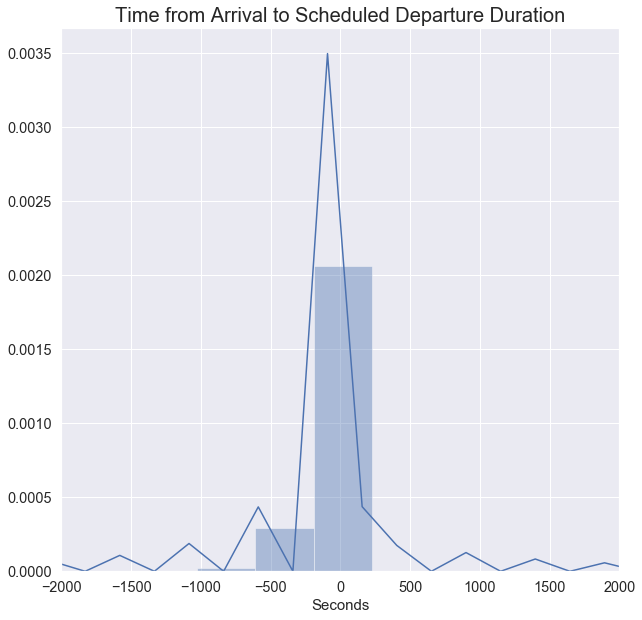

In [40]:
# Create a field that measures seconds from ARRIVAL to TIME_SCHEDULED, i.e. time from arrival to scheduled departure
train_df['TIME_TO_SCH_DEPART'] = (train_df['TIME_SCHEDULED'] - train_df['ARRIVAL'])
train_df['TIME_TO_SCH_DEPART'] = train_df['TIME_TO_SCH_DEPART']/np.timedelta64(1,'s')
plt.figure(figsize=(10,10))
sns.distplot(train_df['TIME_TO_SCH_DEPART'],
            bins = 75)
plt.xlabel('Seconds')
plt.title('Time from Arrival to Scheduled Departure Duration')
plt.xlim((-2000,2000))

The slight skew to the left may indicate that arrivals are occuring after trains' scheduled departures for a substantial portion of trips.

# Populate a COUNTY for every record

NOAA (National Oceanic and Atmospheric) organization provides hourly weather data for US counties.
To merge the hourly weather data into the train data (which featured lower in notebook), the COUNTY field will need to be populated for every record.
Some COUNTY values are missing. These will be researched manually. Additionally, NOAA does not offer weather data for Douglas County, so these will be replaced with Arapahoe, a neighboring county.

In [41]:
# Create new county lookup field.
train_df['LOOKUP_COUNTY'] = train_df['COUNTY']

In [42]:
# Set stations in Douglas county to Arapahoe County for weather lookup.
# Note that Sky Ridge Station, Lone Tree City Center Station, and Ridgegate Parkway Station are in Douglas County 
# despite having originally null values.
train_df.loc[train_df.COUNTY == 'Douglas','LOOKUP_COUNTY'] = 'Arapahoe'

In [43]:
# Create a csv file of unique STOPNAMEs with null LOOOKUP_COUNTY values.
missing_counties = train_df[train_df.LOOKUP_COUNTY.isnull()]['STOPNAME'].unique() 
pd.DataFrame(missing_counties).to_csv('missing_counties.csv',header=True,index=None)

In [44]:
# Create datafataframe from researched station-county list for those originally missing counties.
missing_counties_list = '../missing_counties_researched.csv'
county_updates = pd.read_csv(missing_counties_list,
                       header=0,
                       sep=',')
county_updates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Station  40 non-null     object
 1   County   40 non-null     object
dtypes: object(2)
memory usage: 768.0+ bytes


In [45]:
# Merge the county lookup to fill the missing counties.
train_df = pd.merge(train_df,
                    county_updates,
                   how='left',
                   left_on = 'STOPNAME',
                   right_on = 'Station')

In [46]:
# Fill the missing LOOKUP_COUNTY with the new County value.
train_df.loc[train_df.LOOKUP_COUNTY.isnull(),'LOOKUP_COUNTY'] = train_df['County']

In [47]:
# Drop the 2 recently merged columns.
train_df = train_df.drop(['Station','County'],axis=1)

In [48]:
# Verify counties.
train_df['LOOKUP_COUNTY'].unique()

array(['Denver', 'Adams', 'Arapahoe', 'Jefferson'], dtype=object)

# Evaluate and Merge Rockies data

Rockies data was sourced via 2 files - 1) 2019 Rockies game scores and 2) Denver Post's published 2019 games. 
Since MLB games are fluid, i.e. game cancellations, rescheduled games, doubleheaders, etc, MLB schedules are not followed thoroughly.
Thus, the scores of games that occurred will need to be merged with the scheduled times to capture the start times of actual games played.
Additionally, the 2019 Rockies schedule included double-headers on 7/15 and 7/24 and a cancelled game on 5/8.

In [49]:
# Read the Rockies data in from an excel file.
rockies_file = '../rockies.xlsx'
rockies_games = pd.read_excel(rockies_file, 
                              sheet_name = 'sports_ref',
                             usecols = [1,4,5,16,17]
                             ,names = ['Date','At','Opp','Duration','Day/Night'])
rockies_times = pd.read_excel(rockies_file, 
                              sheet_name = 'DP',
                             usecols = [0,1,2])

In [50]:
# Set Date columns to datetime objects
rockies_times['Date'] = pd.to_datetime(rockies_times['Date'], errors='coerce')
rockies_games['Date'] = pd.to_datetime(rockies_games['Date'],errors = 'coerce')


In [51]:
# View NA dates in games files and fill them out according to double headers held on July 15th and 24th.
rockies_games.loc[rockies_games.Date.isnull()]
rockies_games[91:103]
rockies_games.iloc[92:94,0] = pd.to_datetime('2019-07-15')
rockies_games.iloc[100:102,0] = pd.to_datetime('2019-07-24')

In [52]:
# Remove away games.
rockies_games.head(3)
away_indc = rockies_games[rockies_games.At == '@'].index
rockies_games.drop(away_indc, inplace=True)
rockies_games.head(3)

,Date,At,Opp,Duration,Day/Night
7,2019-04-05,NaN,LAD,03:52:00,D
8,2019-04-06,NaN,LAD,03:19:00,N
9,2019-04-07,NaN,LAD,03:52:00,N


In [53]:
# Remove away games and all star break.
away_indc_times = rockies_times[rockies_times.Opponent.str.startswith('at')].index
rockies_times.drop(away_indc_times, inplace=True)
all_star_game = rockies_times[rockies_times.Opponent == 'All-Star Break'].index
rockies_times.drop(all_star_game, inplace=True)

In [54]:
# Reset indeces.
rockies_games.reset_index(drop=True, inplace=True)
rockies_times.reset_index(drop=True, inplace=True)

In [55]:
# Create 2 lists to capture unique opponent teamname abbreviations (Opp) and definitions (Opponent). These lists are equal in length.
Abbr_Lookup = list(rockies_games.Opp.unique())
Abbr_Def = list(rockies_times.Opponent.unique())

In [56]:
# Create a dictionary defining each teamname abbreviation with its actual teamname.
MLB_team_dict = dict(zip(Abbr_Def, Abbr_Lookup))
print(MLB_team_dict)
# Map these teamnames into the schedule file.
rockies_times['Opp_Cd'] = rockies_times['Opponent'].map(MLB_team_dict)

{'Los Angeles Dodgers': 'LAD', 'Atlanta Braves': 'ATL', 'Philadelphia Phillies': 'PHI', 'Washington Nationals': 'WSN', 'Arizona Diamondbacks': 'ARI', 'San Francisco Giants': 'SFG', 'San Diego Padres': 'SDP', 'Baltimore Orioles': 'BAL', 'Toronto Blue Jays': 'TOR', 'Chicago Cubs': 'CHC', 'Houston Astros': 'HOU', 'Cincinnati Reds': 'CIN', 'Miami Marlins': 'MIA', 'Boston Red Sox': 'BOS', 'Pittsburgh Pirates': 'PIT', 'St. Louis Cardinals': 'STL', 'New York Mets': 'NYM', 'Milwaukee Brewers': 'MIL'}


In [57]:
# Merge rockies_games (scores file) with rockies_times (schedule file) ensuring the dates and opponents match.
rockies_times.rename(columns = {'Date':'Sch_Date'}, inplace = True)
rockies = pd.merge(rockies_games,
                  rockies_times,
                  how = 'left',
                  left_on = ['Date','Opp'],
                  right_on = ['Sch_Date','Opp_Cd'],
                  suffixes = ('_act','_sch'))

In [58]:
# Validate dataframe with merged actual day and scheduled time. Valdate opponents and date scheduled and occurred.

rockies.groupby('Date').size().sort_values(ascending=False)

# Game on May 8th was cancelled and added in as a double-header on July 15th. The Double-Header began at 12:10PM.
# Confirm cancelled game on May 8th does not appear.
rockies.loc[rockies.Date.dt.month == 5]

# Reassign 12:10 to 1st of Double-Header on July 15th.
rockies.at[46,'Time'] = '12:10 p.m.'

In [59]:
# Update re-scheduled final ATL series closer on August 26th that started at 3:10pm.
rockies.at[62,'Time'] = '3:10 p.m.'

# Evaluate Broncos data

Broncos data was sourced in 2 files - 1) 2018 season and 2) 2019 season. These files are read in and games not played in Denver are removed.

In [60]:
# Read the Broncos data in from an excel file.
broncos_file = '../broncos.xlsx'
broncos_games_18 = pd.read_excel(broncos_file
                             ,skiprows = 1
                             ,header = 0
                             ,parse_dates = True,
                             date_parser = True,
                             sheet_name = '2018',
                             usecols = [0,2,3,5,6,8,9],
                             names = ['Week','Date', 'Time','Result','OT','At','Opp'])
broncos_games_19 = pd.read_excel(broncos_file
                             ,skiprows = 1
                             ,header = 0
                             ,parse_dates = True,
                             date_parser = True,
                             sheet_name = '2019',
                             usecols = [0,2,3,5,6,8,9],
                             names = ['Week','Date', 'Time','Result','OT','At','Opp'])
broncos_games_19.head(3)

,Week,Date,Time,Result,OT,At,Opp
0,1,2019-09-09,10:20PM ET,L,NaN,@,Oakland Raiders
1,2,2019-09-15,4:25PM ET,L,NaN,NaN,Chicago Bears
2,3,2019-09-22,1:00PM ET,L,NaN,@,Green Bay Packers


In [61]:
broncos_games_18.info()
broncos_games_19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Week    17 non-null     int64         
 1   Date    16 non-null     datetime64[ns]
 2   Time    16 non-null     object        
 3   Result  16 non-null     object        
 4   OT      0 non-null      float64       
 5   At      8 non-null      object        
 6   Opp     17 non-null     object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 1.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Week    17 non-null     int64         
 1   Date    16 non-null     datetime64[ns]
 2   Time    16 non-null     object        
 3   Result  16 non-null     object        
 4   OT      0 non-null      float64       
 5   At    

In [62]:
# Combine the 2 season files together.
broncos = broncos_games_18.append(broncos_games_19, ignore_index=True)
print(broncos.head(3))
print(broncos.tail(3))

   Week       Date       Time Result  OT   At               Opp
0     1 2018-09-09  4:25PM ET      W NaN  NaN  Seattle Seahawks
1     2 2018-09-16  4:25PM ET      W NaN  NaN   Oakland Raiders
2     3 2018-09-23  1:00PM ET      L NaN    @  Baltimore Ravens
    Week       Date       Time Result  OT   At                 Opp
31    15 2019-12-15  1:00PM ET      L NaN    @  Kansas City Chiefs
32    16 2019-12-22  4:05PM ET      W NaN  NaN       Detroit Lions
33    17 2019-12-29  4:25PM ET      W NaN  NaN     Oakland Raiders


In [63]:
# Drop Bye Week rows and away games.
broncos.dropna(thresh=5,inplace=True)

broncos = broncos.loc[broncos.At.isnull()]
broncos.reset_index(inplace=True,
                   drop=True)

# Evaluate Nuggets data

Nuggets data was sourced in 2 files - 1) 2018 season and 2) 2019 season. These files are read in and games not played in Denver are removed.

In [64]:
# Read the Nuggets data in from an excel file.
nuggets_sheets = pd.ExcelFile('../nuggets.xlsx')
nuggets_sheets.sheet_names

nuggets_file = '../nuggets.xlsx'
nuggets_games_18_19 = pd.read_excel(nuggets_file,
                             header = 0,
                             parse_dates = True,
                             date_parser = True,
                             sheet_name = '2018_2019',
                             usecols = [0,1,2,5,6,8],
                             names = ['G','Date', 'Time','At','Opponent','OT']
                                   )
nuggets_games_19_20 = pd.read_excel(nuggets_file,
                             header = 0,
                             parse_dates = True,
                             date_parser = True,
                             sheet_name = '2019_2020',
                             usecols = [0,1,2,5,6,8],
                             names = ['G','Date', 'Time','At','Opponent','OT']
                                   )

# Update date fields to datetime objects.
nuggets_games_18_19['Date'] = pd.to_datetime(nuggets_games_18_19['Date'], errors='coerce')
nuggets_games_19_20['Date'] = pd.to_datetime(nuggets_games_19_20['Date'], errors='coerce')
print(nuggets_games_19_20.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   G         82 non-null     int64         
 1   Date      82 non-null     datetime64[ns]
 2   Time      82 non-null     object        
 3   At        41 non-null     object        
 4   Opponent  82 non-null     object        
 5   OT        3 non-null      object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 4.0+ KB
None


In [65]:
nuggets_games_18_19.head(3)

,G,Date,Time,At,Opponent,OT
0,1,2018-10-17,10:30p,@,Los Angeles Clippers,NaN
1,2,2018-10-20,9:00p,NaN,Phoenix Suns,NaN
2,3,2018-10-21,8:00p,NaN,Golden State Warriors,NaN


In [66]:
# Combine the 2 season files together.
nuggets = nuggets_games_18_19.append(nuggets_games_19_20,
                          ignore_index=True)
nuggets = nuggets[nuggets.At.isnull()]

# Evaluate Avalanche data

Avalanche data was sourced in 2 files - 1) 2018 season and 2) 2019 season. These files are read in and games not played in Denver are removed.

In [67]:
# Read the Avalanche data in from an excel file.
avs_sheets = pd.ExcelFile('../avalanche.xlsx')
print(avs_sheets.sheet_names)

avs_file = '../avalanche.xlsx'
avs_games_1 = pd.read_excel(avs_file,
                             header = 0,
                             parse_dates = True,
                             date_parser = True,
                             sheet_name = 'Altitude 1',
                             usecols = [0,1,2],
                             names = ['Date', 'Time','At']
                                   )
avs_games_2 = pd.read_excel(avs_file,
                             header = 0,
                             parse_dates = True,
                             date_parser = True,
                             sheet_name = 'Altitude 2',
                             usecols = [0,1,2],
                             names = ['Date', 'Time','At']
                                   )

['2019_2020', 'DP_2018_19', 'DP_2019_20', 'Altitude 1', 'Altitude 2', '2018_2020']


In [68]:
# Update date fields to datetime objects.
avs_games_1['Date'] = pd.to_datetime(avs_games_1.Date, errors = 'coerce')
avs_games_2['Date'] = pd.to_datetime(avs_games_2.Date, errors = 'coerce')

In [69]:
 avs = avs_games_1.append(avs_games_2,
                          ignore_index=True)

In [70]:
# Remove away games.
away_inc = avs.loc[avs.At.str.startswith('at')].index
avs.drop(away_inc,
        inplace=True)

# Update Sport Time fields to 24 hours timestamps

Train data features times based on a 24-hour clock. Thus, the start time of local sporting events will need the same format.

In [71]:
# Identify single record in Rockies data Time set to 1 pm and set it to 1:00 pm.
print(rockies['Time'].unique())
print(rockies.loc[rockies.Time == '1 p.m.'])
rockies.at[80,'Time'] = '1:00 p.m.'
print(rockies['Time'].unique())

['2:10 p.m.' '6:10 p.m.' '1:10 p.m.' '6:40 p.m.' '7:10 p.m.' '6:15 p.m.'
 '12:10 p.m.' '3:10 p.m.' '1 p.m.']
         Date   At  Opp  Duration Day/Night   Sch_Date           Opponent  \
80 2019-09-29  NaN  MIL  04:02:00         D 2019-09-29  Milwaukee Brewers   

      Time Opp_Cd  
80  1 p.m.    MIL  
['2:10 p.m.' '6:10 p.m.' '1:10 p.m.' '6:40 p.m.' '7:10 p.m.' '6:15 p.m.'
 '12:10 p.m.' '3:10 p.m.' '1:00 p.m.']


In [72]:
# Set Rockies time to datetime time object.
rockies['Time'] = pd.to_datetime(rockies['Time']).dt.time

In [73]:
# Create datetime object for Broncos times to make it timezone aware for conversion to MT.
broncos['Game_Time'] = pd.to_datetime(broncos['Date'].dt.strftime('%Y-%m-%d') + ' ' + broncos['Time'].astype(str))

C:\Users\jsummer\AppData\Local\Continuum\anaconda3\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [74]:
# Convert from ET to MT and use time method on datetime to replace originally ET time in Time field
broncos.Game_Time = broncos.Game_Time.dt.tz_localize(tz='US/Eastern').dt.tz_convert('US/Mountain').dt.tz_localize(None)
broncos.Time = broncos.Game_Time.dt.time

In [75]:
# Set Nuggets time to datetime time object.
nuggets['Time'] = pd.to_datetime(nuggets['Time']).dt.time

In [76]:
# Set AValanche time to datetime time object.
avs['Time'] = pd.to_datetime(avs['Time']).dt.time

# Merge sporting events in with train data

The Time of any Broncos, Avalanche, and Nuggets games will be brougt into each record of train data that has a matching SCHEDULED_DAY. The Date of the game will be brought in for additional validation as well.
Since the Rockies played one home double-header, the merged Rockies data will need to feature 2 columns corresponding to the 2 game start times on that day, if applicable.

In [77]:
# Merge in Broncos based on matching dates.
trains_broncos = train_df.merge(broncos[['Date','Time']],
                             how = 'left',
                             left_on = 'SCHEDULED_DAY',
                             right_on ='Date',
                             suffixes=('','_broncos'))
trains_broncos.rename(columns={'Date':'Broncos_Date','Time':'Broncos_Time'},inplace=True)

# Validate successful merge.
trains_broncos[trains_broncos.Broncos_Date.notnull()]

,SERIAL_NUMBER,SCHEDULE_NAME,SIGNUP_NAME,SURVEY_SOURCE,PATTERN_ID,BRANCH,ROUTE_NUMBER,ROUTE_NAME,DIRECTION_NAME,SERVICE_TYPE,...,LONGITUDE,SCHEDULED_DAY,ARRIVAL_TIME,DEPART_TIME,ARRIVAL,DEPARTURE,TIME_TO_SCH_DEPART,LOOKUP_COUNTY,Broncos_Date,Broncos_Time
54028,35136927,Aug18 (Friday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,NaN,2018-12-15,00:00:10,00:00:10,2018-12-15 00:00:10,2018-12-15 00:00:10,-10.0,Denver,2018-12-15,18:20:00
54029,35136927,Aug18 (Friday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,NaN,2018-12-15,00:04:15,00:04:51,2018-12-15 00:04:15,2018-12-15 00:04:51,-15.0,Denver,2018-12-15,18:20:00
54030,35136927,Aug18 (Friday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,NaN,2018-12-15,00:08:54,00:09:29,2018-12-15 00:08:54,2018-12-15 00:09:29,6.0,Denver,2018-12-15,18:20:00
54031,35136927,Aug18 (Friday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,NaN,2018-12-15,00:13:23,00:14:00,2018-12-15 00:13:23,2018-12-15 00:14:00,-23.0,Denver,2018-12-15,18:20:00
54032,35136927,Aug18 (Friday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,NaN,2018-12-15,00:16:37,00:17:13,2018-12-15 00:16:37,2018-12-15 00:17:13,-37.0,Adams,2018-12-15,18:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1683601,40510289,Aug19 (Sunday),Aug19,3,1119206,W,103,103: Light Rail W Line,east,Light Rail,...,-105.023633,2019-11-03,18:43:22,18:43:56,2019-11-03 18:43:22,2019-11-03 18:43:56,38.0,Denver,2019-11-03,14:25:00
1683602,40510289,Aug19 (Sunday),Aug19,3,1119206,W,103,103: Light Rail W Line,east,Light Rail,...,-105.010937,2019-11-03,18:46:55,18:47:36,2019-11-03 18:46:55,2019-11-03 18:47:36,5.0,Denver,2019-11-03,14:25:00
1683603,40510289,Aug19 (Sunday),Aug19,3,1119206,W,103,103: Light Rail W Line,east,Light Rail,...,-105.013526,2019-11-03,18:48:47,18:49:16,2019-11-03 18:48:47,2019-11-03 18:49:16,-32.0,Denver,2019-11-03,14:25:00
1683604,40510289,Aug19 (Sunday),Aug19,3,1119206,W,103,103: Light Rail W Line,east,Light Rail,...,-105.009430,2019-11-03,18:50:46,18:51:11,2019-11-03 18:50:46,2019-11-03 18:51:11,-46.0,Denver,2019-11-03,14:25:00


In [78]:
# Merge in Nuggets based on matching dates.
trains_broncos_nuggets = trains_broncos.merge(nuggets[['Date','Time']],
                             how = 'left',
                             left_on = 'SCHEDULED_DAY',
                             right_on ='Date',
                             suffixes=('','_nuggets'))
trains_broncos_nuggets.rename(columns={'Date':'Nuggets_Date','Time':'Nuggets_Time'},inplace=True)

# Validate successful merge.
trains_broncos_nuggets[trains_broncos_nuggets.Nuggets_Date.notnull()]

,SERIAL_NUMBER,SCHEDULE_NAME,SIGNUP_NAME,SURVEY_SOURCE,PATTERN_ID,BRANCH,ROUTE_NUMBER,ROUTE_NAME,DIRECTION_NAME,SERVICE_TYPE,...,ARRIVAL_TIME,DEPART_TIME,ARRIVAL,DEPARTURE,TIME_TO_SCH_DEPART,LOOKUP_COUNTY,Broncos_Date,Broncos_Time,Nuggets_Date,Nuggets_Time
32393,35028316,Aug18 (Sunday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,00:00:27,00:00:27,2018-12-10 00:00:27,2018-12-10 00:00:27,-27.0,Denver,NaT,NaN,2018-12-10,21:00:00
32394,35028316,Aug18 (Sunday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,00:04:40,00:05:24,2018-12-10 00:04:40,2018-12-10 00:05:24,-40.0,Denver,NaT,NaN,2018-12-10,21:00:00
32395,35028316,Aug18 (Sunday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,00:09:27,00:10:09,2018-12-10 00:09:27,2018-12-10 00:10:09,-27.0,Denver,NaT,NaN,2018-12-10,21:00:00
32396,35028316,Aug18 (Sunday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,00:14:03,00:14:40,2018-12-10 00:14:03,2018-12-10 00:14:40,-63.0,Denver,NaT,NaN,2018-12-10,21:00:00
32397,35028316,Aug18 (Sunday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,00:17:23,00:18:02,2018-12-10 00:17:23,2018-12-10 00:18:02,-83.0,Adams,NaT,NaN,2018-12-10,21:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1817912,40690786,Aug19 (Sunday),Aug19,3,1119206,W,103,103: Light Rail W Line,east,Light Rail,...,10:13:42,10:14:15,2019-11-24 10:13:42,2019-11-24 10:14:15,18.0,Denver,NaT,NaN,2019-11-24,20:00:00
1817913,40690786,Aug19 (Sunday),Aug19,3,1119206,W,103,103: Light Rail W Line,east,Light Rail,...,10:16:55,10:17:27,2019-11-24 10:16:55,2019-11-24 10:17:27,5.0,Denver,NaT,NaN,2019-11-24,20:00:00
1817914,40690786,Aug19 (Sunday),Aug19,3,1119206,W,103,103: Light Rail W Line,east,Light Rail,...,10:18:22,10:18:37,2019-11-24 10:18:22,2019-11-24 10:18:37,-7.0,Denver,NaT,NaN,2019-11-24,20:00:00
1817915,40690786,Aug19 (Sunday),Aug19,3,1119206,W,103,103: Light Rail W Line,east,Light Rail,...,10:20:08,10:20:24,2019-11-24 10:20:08,2019-11-24 10:20:24,-8.0,Denver,NaT,NaN,2019-11-24,20:00:00


In [79]:
# Merge in Avalanche based on matching dates.
trains_broncos_nuggets_avs = trains_broncos_nuggets.merge(avs[['Date','Time']],
                             how = 'left',
                             left_on = 'SCHEDULED_DAY',
                             right_on ='Date',
                             suffixes=('','_avs'))
trains_broncos_nuggets_avs.rename(columns={'Date':'Avs_Date','Time':'Avs_Time'},inplace=True)

# Validate successful merge.
trains_broncos_nuggets_avs[trains_broncos_nuggets_avs.Avs_Date.notnull()]

,SERIAL_NUMBER,SCHEDULE_NAME,SIGNUP_NAME,SURVEY_SOURCE,PATTERN_ID,BRANCH,ROUTE_NUMBER,ROUTE_NAME,DIRECTION_NAME,SERVICE_TYPE,...,ARRIVAL,DEPARTURE,TIME_TO_SCH_DEPART,LOOKUP_COUNTY,Broncos_Date,Broncos_Time,Nuggets_Date,Nuggets_Time,Avs_Date,Avs_Time
35765,35039985,Aug18 (Mon-Thu),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,2018-12-11 00:30:08,2018-12-11 00:30:08,-8.0,Denver,NaT,NaN,NaT,NaN,2018-12-11,18:00:00
35766,35039985,Aug18 (Mon-Thu),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,2018-12-11 00:34:25,2018-12-11 00:35:02,-25.0,Denver,NaT,NaN,NaT,NaN,2018-12-11,18:00:00
35767,35039985,Aug18 (Mon-Thu),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,2018-12-11 00:39:04,2018-12-11 00:39:42,-4.0,Denver,NaT,NaN,NaT,NaN,2018-12-11,18:00:00
35768,35039985,Aug18 (Mon-Thu),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,2018-12-11 00:43:53,2018-12-11 00:44:30,-53.0,Denver,NaT,NaN,NaT,NaN,2018-12-11,18:00:00
35769,35039985,Aug18 (Mon-Thu),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,2018-12-11 00:47:17,2018-12-11 00:47:55,-77.0,Adams,NaT,NaN,NaT,NaN,2018-12-11,18:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1838220,40690705,Aug19 (Saturday),Aug19,3,1119213,W,103,103: Light Rail W Line,west,Light Rail,...,2019-11-30 19:19:25,2019-11-30 19:20:01,-100.0,Jefferson,NaT,NaN,NaT,NaN,2019-11-30,18:00:00
1838221,40690705,Aug19 (Saturday),Aug19,3,1119213,W,103,103: Light Rail W Line,west,Light Rail,...,2019-11-30 19:21:52,2019-11-30 19:22:11,-97.0,Jefferson,NaT,NaN,NaT,NaN,2019-11-30,18:00:00
1838222,40690705,Aug19 (Saturday),Aug19,3,1119213,W,103,103: Light Rail W Line,west,Light Rail,...,2019-11-30 19:24:14,2019-11-30 19:24:47,-89.0,Jefferson,NaT,NaN,NaT,NaN,2019-11-30,18:00:00
1838223,40690705,Aug19 (Saturday),Aug19,3,1119213,W,103,103: Light Rail W Line,west,Light Rail,...,2019-11-30 19:27:29,2019-11-30 19:28:03,-104.0,Jefferson,NaT,NaN,NaT,NaN,2019-11-30,18:00:00


In [80]:
# Create a new dataframe showing the first game played for each game day.
rockies_starting_gm = rockies.groupby(['Date','Opp'],
                                   as_index=False).first()

# Merge the prior dataframe with the last game played for each game day.
rockies_games_consld = rockies_starting_gm.join(rockies.groupby(['Date','Opp'],
                                   as_index=False).last(),
                                   how='left',
                                   lsuffix='_1st',
                                   rsuffix='_2nd')

# Remove duplicative fields.
rockies_games_consld = rockies_games_consld.drop(['Date_2nd','Opp_2nd'], axis=1)    

# Rename fields.
rockies_games_consld.rename(columns={'Date_1st':'Date','Opp_1st':'Opp'},inplace=True)


In [81]:
# Capture indexes of records wherein only a single game was played.
duplicate = rockies_games_consld[rockies_games_consld.Time_1st == rockies_games_consld.Time_2nd].index

# Set the 2nd game time of these records to null and subsequently NaN. 
rockies_games_consld.iloc[duplicate,3] = ''
rockies_games_consld = rockies_games_consld.replace(r'^\s*$', np.nan, regex=True)

In [82]:
# Verify row corresponding to double header on 7/15.
rockies_games_consld[rockies_games_consld.Date == '2019-07-15']

,Date,Opp,At_1st,Duration_1st,Day/Night_1st,Sch_Date_1st,Opponent_1st,Time_1st,Opp_Cd_1st,At_2nd,Duration_2nd,Day/Night_2nd,Sch_Date_2nd,Opponent_2nd,Time_2nd,Opp_Cd_2nd
46,2019-07-15,SFG,NaN,03:15:00,D,2019-07-15,San Francisco Giants,12:10:00,SFG,NaN,02:42:00,N,2019-07-15,San Francisco Giants,18:40:00,SFG


In [83]:
rockies_games_consld.groupby('Date').count().sort_values('Opp')

,Opp,At_1st,Duration_1st,Day/Night_1st,Sch_Date_1st,Opponent_1st,Time_1st,Opp_Cd_1st,At_2nd,Duration_2nd,Day/Night_2nd,Sch_Date_2nd,Opponent_2nd,Time_2nd,Opp_Cd_2nd
Date,,,,,,,,,,,,,,,
2019-04-05,1,0,0,1,1,1,1,1,0,1,1,1,1,1,1
2019-08-14,1,0,0,1,1,1,1,1,0,1,1,1,1,1,1
2019-08-13,1,0,0,1,1,1,1,1,0,1,1,1,1,1,1
2019-08-12,1,0,0,1,1,1,1,1,0,1,1,1,1,1,1
2019-08-04,1,0,0,1,1,1,1,1,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-27,1,0,0,1,1,1,1,1,0,1,1,1,1,1,1
2019-05-26,1,0,0,1,1,1,1,1,0,1,1,1,1,1,1
2019-05-25,1,0,0,1,1,1,1,1,0,1,1,1,1,1,1


In [84]:
# Merge in Rockies based on matching dates.
trains_games = trains_broncos_nuggets_avs.merge(rockies_games_consld[['Date','Time_1st','Time_2nd']],
                             how = 'left',
                             left_on = 'SCHEDULED_DAY',
                             right_on ='Date',
                             suffixes=('','_rox'))
trains_games.rename(columns={'Date':'Rox_Date','Time_1st':'Rox_Time_1', 'Time_2nd':'Rox_Time_2'},inplace=True)

# Validate successful merge.
trains_games[trains_games.Rox_Date.notnull()]

,SERIAL_NUMBER,SCHEDULE_NAME,SIGNUP_NAME,SURVEY_SOURCE,PATTERN_ID,BRANCH,ROUTE_NUMBER,ROUTE_NAME,DIRECTION_NAME,SERVICE_TYPE,...,LOOKUP_COUNTY,Broncos_Date,Broncos_Time,Nuggets_Date,Nuggets_Time,Avs_Date,Avs_Time,Rox_Date,Rox_Time_1,Rox_Time_2
460221,36651122,Jan19 (Friday),Jan19,3,1091226,B,113,113: Commuter Rail,west,Commuter Rail,...,Denver,NaT,NaN,2019-04-05,22:30:00,NaT,NaN,2019-04-05,14:10:00,14:10:00
460222,36651122,Jan19 (Friday),Jan19,3,1091226,B,113,113: Commuter Rail,west,Commuter Rail,...,Denver,NaT,NaN,2019-04-05,22:30:00,NaT,NaN,2019-04-05,14:10:00,14:10:00
460223,36651502,Jan19 (Friday),Jan19,3,1091226,B,113,113: Commuter Rail,west,Commuter Rail,...,Denver,NaT,NaN,2019-04-05,22:30:00,NaT,NaN,2019-04-05,14:10:00,14:10:00
460224,36651502,Jan19 (Friday),Jan19,3,1091226,B,113,113: Commuter Rail,west,Commuter Rail,...,Denver,NaT,NaN,2019-04-05,22:30:00,NaT,NaN,2019-04-05,14:10:00,14:10:00
460225,36651503,Jan19 (Friday),Jan19,3,1091226,B,113,113: Commuter Rail,west,Commuter Rail,...,Denver,NaT,NaN,2019-04-05,22:30:00,NaT,NaN,2019-04-05,14:10:00,14:10:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1569271,39296095,Aug19 (Sunday),Aug19,3,1119232,R,107,107: Light Rail R Line,south,Light Rail,...,Arapahoe,2019-09-29,14:25:00,NaT,NaN,NaT,NaN,2019-09-29,13:00:00,13:00:00
1569272,39296095,Aug19 (Sunday),Aug19,3,1119232,R,107,107: Light Rail R Line,south,Light Rail,...,Arapahoe,2019-09-29,14:25:00,NaT,NaN,NaT,NaN,2019-09-29,13:00:00,13:00:00
1569273,39296095,Aug19 (Sunday),Aug19,3,1119232,R,107,107: Light Rail R Line,south,Light Rail,...,Arapahoe,2019-09-29,14:25:00,NaT,NaN,NaT,NaN,2019-09-29,13:00:00,13:00:00
1569274,39296095,Aug19 (Sunday),Aug19,3,1119232,R,107,107: Light Rail R Line,south,Light Rail,...,Arapahoe,2019-09-29,14:25:00,NaT,NaN,NaT,NaN,2019-09-29,13:00:00,13:00:00


# Re-calculating Dwell Time

Native train data featured a field labeled DWELL_TIME. However, this field was often null and will need to be re-calculated as WAIT_TIME_CALC,
corresponding to the time (in seconds) between DEPARTURE and ARRIVAL

In [85]:
# Calculate WAIT_TIME_CALC in seconds.
trains_games['WAIT_TIME_CALC'] = (trains_games['DEPARTURE'] - trains_games['ARRIVAL'])
trains_games['WAIT_TIME_CALC'] = trains_games['WAIT_TIME_CALC']/np.timedelta64(1,'s')

# Validate field creation.
trains_games[['TIME_SCHEDULED',
            'ARRIVAL',
            'DEPARTURE',
            'DWELL_TIME',
            'WAIT_TIME_CALC']]

,TIME_SCHEDULED,ARRIVAL,DEPARTURE,DWELL_TIME,WAIT_TIME_CALC
0,2018-12-01 00:57:00,2018-12-01 00:57:11,2018-12-01 00:57:11,NaN,0.0
1,2018-12-01 01:06:00,2018-12-01 01:06:51,2018-12-01 01:07:15,NaN,24.0
2,2018-12-01 01:10:00,2018-12-01 01:10:18,2018-12-01 01:10:46,NaN,28.0
3,2018-12-01 01:16:00,2018-12-01 01:16:09,2018-12-01 01:16:46,NaN,37.0
4,2018-12-01 01:19:00,2018-12-01 01:19:41,2018-12-01 01:20:30,NaN,49.0
...,...,...,...,...,...
1838220,2019-11-30 19:17:45,2019-11-30 19:19:25,2019-11-30 19:20:01,NaN,36.0
1838221,2019-11-30 19:20:15,2019-11-30 19:21:52,2019-11-30 19:22:11,NaN,19.0
1838222,2019-11-30 19:22:45,2019-11-30 19:24:14,2019-11-30 19:24:47,NaN,33.0
1838223,2019-11-30 19:25:45,2019-11-30 19:27:29,2019-11-30 19:28:03,NaN,34.0


# Delayed Departure Creation

RTD assesses the time performance of their trains by comparing actual departure with scheduled departure. A new field, DEPARTURE_DELAY
will be created to do this by calculating the seconds between DEPARTURE and TIME_SCHEDULED. Negative DEPARTURE_DELAY indicates DEPARTURE 
happened prior to TIME_SCHEDULED departure. Postiive DEPARTURE_DELAY indicates DEPARTURE happened after TIME_SCHEDULED departure and thus is late.

In [86]:
# Create DEPARTURE_DELAY indicating how many seconds after the scheduled departure did the actual departure occur.
trains_games['DEPARTURE_DELAY'] = (trains_games['DEPARTURE'] - trains_games['TIME_SCHEDULED'])
trains_games['DEPARTURE_DELAY'] = trains_games['DEPARTURE_DELAY']/np.timedelta64(1,'s')

# Validate field creation.
trains_games[['TIME_SCHEDULED',
            'ARRIVAL',
            'DEPARTURE',
            'DWELL_TIME',
            'WAIT_TIME_CALC',
            'DEPARTURE_DELAY']]

,TIME_SCHEDULED,ARRIVAL,DEPARTURE,DWELL_TIME,WAIT_TIME_CALC,DEPARTURE_DELAY
0,2018-12-01 00:57:00,2018-12-01 00:57:11,2018-12-01 00:57:11,NaN,0.0,11.0
1,2018-12-01 01:06:00,2018-12-01 01:06:51,2018-12-01 01:07:15,NaN,24.0,75.0
2,2018-12-01 01:10:00,2018-12-01 01:10:18,2018-12-01 01:10:46,NaN,28.0,46.0
3,2018-12-01 01:16:00,2018-12-01 01:16:09,2018-12-01 01:16:46,NaN,37.0,46.0
4,2018-12-01 01:19:00,2018-12-01 01:19:41,2018-12-01 01:20:30,NaN,49.0,90.0
...,...,...,...,...,...,...
1838220,2019-11-30 19:17:45,2019-11-30 19:19:25,2019-11-30 19:20:01,NaN,36.0,136.0
1838221,2019-11-30 19:20:15,2019-11-30 19:21:52,2019-11-30 19:22:11,NaN,19.0,116.0
1838222,2019-11-30 19:22:45,2019-11-30 19:24:14,2019-11-30 19:24:47,NaN,33.0,122.0
1838223,2019-11-30 19:25:45,2019-11-30 19:27:29,2019-11-30 19:28:03,NaN,34.0,138.0


In [87]:
# Create a flag field DELAYED_FLG which will show 1 to indicate if the departure was delayed (in comparison to its scheduled departure).
trains_games['DELAYED_FLG'] = 0
trains_games.loc[trains_games.DEPARTURE_DELAY > 0,'DELAYED_FLG'] = 1

In [88]:
# Final check to ensure critical fields do not have any null values.
print(trains_games.info(verbose=True, null_counts=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1838225 entries, 0 to 1838224
Data columns (total 60 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   SERIAL_NUMBER          1838225 non-null  int64         
 1   SCHEDULE_NAME          1838225 non-null  object        
 2   SIGNUP_NAME            1838225 non-null  object        
 3   SURVEY_SOURCE          1838225 non-null  int64         
 4   PATTERN_ID             1838225 non-null  int64         
 5   BRANCH                 1838225 non-null  object        
 6   ROUTE_NUMBER           1838225 non-null  int64         
 7   ROUTE_NAME             1838225 non-null  object        
 8   DIRECTION_NAME         1838225 non-null  object        
 9   SERVICE_TYPE           1838225 non-null  object        
 10  SERVICE_MODE           1836357 non-null  object        
 11  SURVEY_DATE_EFFECTIVE  1838225 non-null  object        
 12  SURVEY_DATE_ATYPICAL   18382

# Initial Analysis Performed on Train for Insights and Anamolies

The following section begins to explore the sourced and merged data to identify trends, anamolies, and possible areas for further investigation. 
Analysis in the following section references dataframe 'trains_games' that features both train departure data alongside of local sporting event times.
Weather data is merged into this dataframe and further explored alongside of train performance further down. 

# Explore Delays by Branch

In [89]:
# Set plotting layout to seaborn default style
sns.set_style()

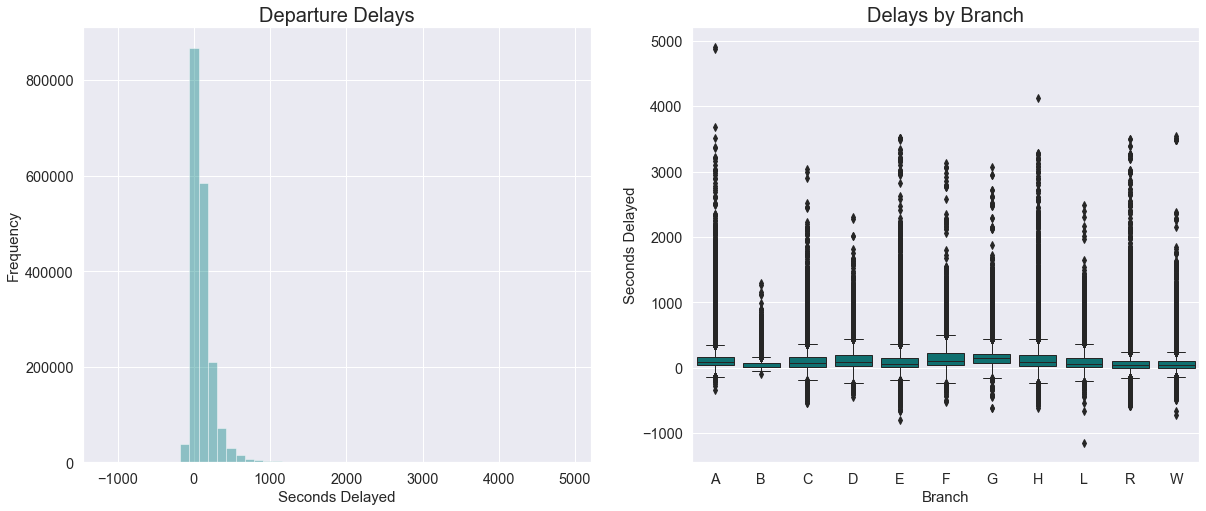

In [90]:
# Create a smaller dataframe sorted by branch to evaluate delays by branch
delays = trains_games[['BRANCH',
                        'DIRECTION_NAME',
                        'FREE_RUNNING',
                        'STOPNAME',
                        'DEPARTURE_DELAY',
                        'DELAYED_FLG',
                        'TIME_PERIOD']].sort_values('BRANCH')

# View distribution of delays once again
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
_ = sns.distplot(delays['DEPARTURE_DELAY'],
                 color='teal',
                kde=False)
plt.ylabel('Frequency')
plt.xlabel('Seconds Delayed')
plt.title('Departure Delays')
          
# Create a boxplot of delays by Branch
plt.subplot(1,2,2)
_ = sns.boxplot(x='BRANCH',
             y='DEPARTURE_DELAY',
             data = delays,
             showfliers=True,
             color='teal',
               linewidth=1)
plt.ylabel('Seconds Delayed')
plt.xlabel('Branch')
plt.title('Delays by Branch')
plt.show()

Evaluating delays by branch shows at least 3 possible outliers - 2 above 4000 seconds delayed departure and 1 less than -1000 seconds delayed. These records are viewed below for further investigation. 
They correspond to the end of lines. Measuring departures at the end of lines will likely inflate departure delay records and should be removed. As a result, line end points should be removed.

In [91]:
# Verify possible outliers of above 4000 seconds delayed and below -1000 seconds delayed
display(trains_games[['BRANCH',
              'DEPARTURE',
              'DIRECTION_NAME',
              'FREE_RUNNING',
              'STOPNAME',
              'DEPARTURE_DELAY',
              'ARRIVAL',
              'TIME_SCHEDULED',
              'SIGNUP_NAME',
              'ROUTE_NUMBER',
              'BLOCK_NUMBER',
              'SERVICE_PERIOD',
              'SERIAL_NUMBER',
              'STOP_ID'
             ]].loc[trains_games.DEPARTURE_DELAY >= 4000])

display(trains_games[['BRANCH',
              'DEPARTURE',
              'DIRECTION_NAME',
              'FREE_RUNNING',
              'STOPNAME',
              'DEPARTURE_DELAY',
              'ARRIVAL',
              'TIME_SCHEDULED',
              'SIGNUP_NAME',
              'ROUTE_NUMBER',
              'BLOCK_NUMBER',
              'SERVICE_PERIOD',
              'SERIAL_NUMBER',
              'STOP_ID'
             ]].loc[trains_games.DEPARTURE_DELAY <= -1000])

,BRANCH,DEPARTURE,DIRECTION_NAME,FREE_RUNNING,STOPNAME,DEPARTURE_DELAY,ARRIVAL,TIME_SCHEDULED,SIGNUP_NAME,ROUTE_NUMBER,BLOCK_NUMBER,SERVICE_PERIOD,SERIAL_NUMBER,STOP_ID
279630,A,2019-02-20 15:55:42,west,NaN,Union Station Track 1,4902.0,2019-02-20 14:40:20,2019-02-20 14:34:00,Jan19,111,3,Mon-Thu,36353652,34667
431001,A,2019-03-29 12:10:14,west,NaN,Union Station Track 1,4874.0,2019-03-29 11:06:00,2019-03-29 10:49:00,Jan19,111,7,Saturday,36636178,34667
502979,H,2019-04-15 23:51:44,south,0.0,Florida Station,4124.0,2019-04-15 23:31:43,2019-04-15 22:43:00,Jan19,101,53,Mon-Thu,36767026,34577


,BRANCH,DEPARTURE,DIRECTION_NAME,FREE_RUNNING,STOPNAME,DEPARTURE_DELAY,ARRIVAL,TIME_SCHEDULED,SIGNUP_NAME,ROUTE_NUMBER,BLOCK_NUMBER,SERVICE_PERIOD,SERIAL_NUMBER,STOP_ID
262196,L,2019-02-16 06:36:24,south,0.0,30th & Downing Station,-1146.0,2019-02-16 06:36:24,2019-02-16 06:55:30,Jan19,109,7,Saturday,36090758,23051


In [92]:
trains_games.loc[trains_games.BRANCH == 'R'].head(5)

,SERIAL_NUMBER,SCHEDULE_NAME,SIGNUP_NAME,SURVEY_SOURCE,PATTERN_ID,BRANCH,ROUTE_NUMBER,ROUTE_NAME,DIRECTION_NAME,SERVICE_TYPE,...,Nuggets_Date,Nuggets_Time,Avs_Date,Avs_Time,Rox_Date,Rox_Time_1,Rox_Time_2,WAIT_TIME_CALC,DEPARTURE_DELAY,DELAYED_FLG
46,34902622,Aug18 (Saturday),Aug18,3,1083603,R,107,107: Light Rail R Line,south,Light Rail,...,NaT,NaN,NaT,NaN,NaT,NaN,NaN,26.0,5.0,1
47,34902622,Aug18 (Saturday),Aug18,3,1083603,R,107,107: Light Rail R Line,south,Light Rail,...,NaT,NaN,NaT,NaN,NaT,NaN,NaN,26.0,5.0,1
48,34902622,Aug18 (Saturday),Aug18,3,1083603,R,107,107: Light Rail R Line,south,Light Rail,...,NaT,NaN,NaT,NaN,NaT,NaN,NaN,17.0,26.0,1
49,34902622,Aug18 (Saturday),Aug18,3,1083603,R,107,107: Light Rail R Line,south,Light Rail,...,NaT,NaN,NaT,NaN,NaT,NaN,NaN,17.0,26.0,1
50,34902622,Aug18 (Saturday),Aug18,3,1083603,R,107,107: Light Rail R Line,south,Light Rail,...,NaT,NaN,NaT,NaN,NaT,NaN,NaN,16.0,9.0,1


In [93]:
# Note that the native field to identify final destinations for each trip is the SORT_ORDER.
# However, there are inconsistencies in SORT_ORDER (specifically for RANCH B) so the below will give the top SORT_ORDER per BRANCH, DIRECTION, SERVICE_PERIOD for further investigation.

branches = ['A','B','C','D','E','F','G','H','L','R','W']
for branch in branches:
    if branch in ('C','D','E','F','H','L','R'):
        directions = ['north','south']
        for direction in directions:
            display(trains_games[['BRANCH',
                            'DIRECTION_NAME',
                            'SERVICE_PERIOD',
                            'SORT_ORDER',
                            'STOPNAME']].loc[(trains_games.BRANCH == branch) &
                                               (trains_games.DIRECTION_NAME == direction)].drop_duplicates().sort_values('SORT_ORDER', ascending=False).head())
    else:
        directions = ['east','west']
        for direction in directions:
            display(trains_games[['BRANCH',
                            'DIRECTION_NAME',
                            'SERVICE_PERIOD',
                            'SORT_ORDER',
                            'STOPNAME']].loc[(trains_games.BRANCH == branch) &
                                               (trains_games.DIRECTION_NAME == direction)].drop_duplicates().sort_values('SORT_ORDER', ascending=False).head())

display(trains_games[['BRANCH',
                            'DIRECTION_NAME',
                            'SERVICE_PERIOD',
                            'SORT_ORDER',
                            'STOPNAME']].loc[trains_games.BRANCH == 'B'].drop_duplicates())

,BRANCH,DIRECTION_NAME,SERVICE_PERIOD,SORT_ORDER,STOPNAME
435285,A,east,Sunday,100,Denver Airport Station
430777,A,east,Saturday,100,Denver Airport Station
416967,A,east,Mon-Thu,100,Denver Airport Station
426143,A,east,Friday,100,Denver Airport Station
426142,A,east,Friday,90,61st/Pena Station Track 1


,BRANCH,DIRECTION_NAME,SERVICE_PERIOD,SORT_ORDER,STOPNAME
435293,A,west,Sunday,90,Union Station Track 1
430785,A,west,Saturday,90,Union Station Track 1
416983,A,west,Mon-Thu,90,Union Station Track 1
426159,A,west,Friday,90,Union Station Track 1
426158,A,west,Friday,80,38th/Blake Station Track 2


,BRANCH,DIRECTION_NAME,SERVICE_PERIOD,SORT_ORDER,STOPNAME
572751,B,east,Sunday,90,41st & Fox Station Track 2
578755,B,east,Mon-Thu,90,41st & Fox Station Track 2
604709,B,east,Friday,90,41st & Fox Station Track 2
611288,B,east,Saturday,90,41st & Fox Station Track 2
64,B,east,Saturday,60,Westminster Station S-Bound


,BRANCH,DIRECTION_NAME,SERVICE_PERIOD,SORT_ORDER,STOPNAME
572835,B,west,Sunday,40,41st & Fox Station Track 1
578652,B,west,Mon-Thu,40,41st & Fox Station Track 1
604493,B,west,Friday,40,41st & Fox Station Track 1
611062,B,west,Saturday,40,41st & Fox Station Track 1
66,B,west,Saturday,30,Union Station Track 8


,BRANCH,DIRECTION_NAME,SERVICE_PERIOD,SORT_ORDER,STOPNAME
701900,C,north,Mon-Thu,430,Union Station Track 11
729785,C,north,Friday,430,Union Station Track 11
735845,C,north,Saturday,430,Union Station Track 11
696166,C,north,Sunday,430,Union Station Track 11
728925,C,north,Friday,420,Pepsi Center / Elitch Gardens Station


,BRANCH,DIRECTION_NAME,SERVICE_PERIOD,SORT_ORDER,STOPNAME
1434441,C,south,Sunday,340,Littleton / Mineral Ave Station {1303}
1363043,C,south,Mon-Thu,340,Littleton / Mineral Ave Station {1303}
1390628,C,south,Friday,340,Littleton / Mineral Ave Station {1303}
1428480,C,south,Saturday,340,Littleton / Mineral Ave Station {1303}
2440,C,south,Sunday,330,Littleton / Mineral Ave Station {1303}


,BRANCH,DIRECTION_NAME,SERVICE_PERIOD,SORT_ORDER,STOPNAME
743048,D,north,Sunday,480,18th & California Station
735809,D,north,Saturday,480,18th & California Station
728825,D,north,Friday,480,18th & California Station
699959,D,north,Mon-Thu,480,18th & California Station
735529,D,north,Saturday,460,16th & California Station


,BRANCH,DIRECTION_NAME,SERVICE_PERIOD,SORT_ORDER,STOPNAME
1399243,D,south,Saturday,340,Littleton / Mineral Ave Station {1303}
1363576,D,south,Mon-Thu,340,Littleton / Mineral Ave Station {1303}
1356663,D,south,Sunday,340,Littleton / Mineral Ave Station {1303}
1390688,D,south,Friday,340,Littleton / Mineral Ave Station {1303}
1399242,D,south,Saturday,330,Littleton / Downtown Station {1303}


,BRANCH,DIRECTION_NAME,SERVICE_PERIOD,SORT_ORDER,STOPNAME
735583,E,north,Saturday,430,Union Station Track 11
694821,E,north,Sunday,430,Union Station Track 11
727247,E,north,Friday,430,Union Station Track 11
700546,E,north,Mon-Thu,430,Union Station Track 11
735582,E,north,Saturday,420,Pepsi Center / Elitch Gardens Station


,BRANCH,DIRECTION_NAME,SERVICE_PERIOD,SORT_ORDER,STOPNAME
1391488,E,south,Friday,490,Ridgegate Parkway Station
1363080,E,south,Mon-Thu,490,Ridgegate Parkway Station
1357651,E,south,Sunday,490,Ridgegate Parkway Station
1399168,E,south,Saturday,490,Ridgegate Parkway Station
1363079,E,south,Mon-Thu,480,Lone Tree City Center Station


,BRANCH,DIRECTION_NAME,SERVICE_PERIOD,SORT_ORDER,STOPNAME
727151,F,north,Friday,480,18th & California Station
699993,F,north,Mon-Thu,480,18th & California Station
727150,F,north,Friday,460,16th & California Station
699992,F,north,Mon-Thu,460,16th & California Station
699991,F,north,Mon-Thu,450,Theatre District / Convention Center Station


,BRANCH,DIRECTION_NAME,SERVICE_PERIOD,SORT_ORDER,STOPNAME
1390662,F,south,Friday,490,Ridgegate Parkway Station
1364917,F,south,Mon-Thu,490,Ridgegate Parkway Station
701465,F,south,Mon-Thu,480,Ridgegate Parkway Station
1390661,F,south,Friday,480,Lone Tree City Center Station
1364916,F,south,Mon-Thu,480,Lone Tree City Center Station


,BRANCH,DIRECTION_NAME,SERVICE_PERIOD,SORT_ORDER,STOPNAME
610969,G,east,Saturday,90,41st & Fox Station Track 2
604466,G,east,Friday,90,41st & Fox Station Track 2
578595,G,east,Mon-Thu,90,41st & Fox Station Track 2
572762,G,east,Sunday,90,41st & Fox Station Track 2
610967,G,east,Saturday,50,Clear Creek - Federal Station Track 2


,BRANCH,DIRECTION_NAME,SERVICE_PERIOD,SORT_ORDER,STOPNAME
611069,G,west,Saturday,120,Wheat Ridge - Ward Station Track 1
572780,G,west,Sunday,120,Wheat Ridge - Ward Station Track 1
604409,G,west,Friday,120,Wheat Ridge - Ward Station Track 1
578533,G,west,Mon-Thu,120,Wheat Ridge - Ward Station Track 1
604408,G,west,Friday,110,Arvada Ridge Station Track 1


,BRANCH,DIRECTION_NAME,SERVICE_PERIOD,SORT_ORDER,STOPNAME
734067,H,north,Saturday,480,18th & California Station
727070,H,north,Friday,480,18th & California Station
699883,H,north,Mon-Thu,480,18th & California Station
695030,H,north,Sunday,480,18th & California Station
695029,H,north,Sunday,460,16th & California Station


,BRANCH,DIRECTION_NAME,SERVICE_PERIOD,SORT_ORDER,STOPNAME
1390748,H,south,Friday,530,Florida Station
1473801,H,south,Sunday,530,Florida Station
1363014,H,south,Mon-Thu,530,Florida Station
1398867,H,south,Saturday,530,Florida Station
727525,H,south,Friday,520,Florida Station


,BRANCH,DIRECTION_NAME,SERVICE_PERIOD,SORT_ORDER,STOPNAME
83065,L,north,Saturday,80,30th & Downing Station
50331,L,north,Friday,80,30th & Downing Station
5341,L,north,Mon-Thu,80,30th & Downing Station
2498,L,north,Sunday,80,30th & Downing Station
83064,L,north,Saturday,70,27th & Welton Station


,BRANCH,DIRECTION_NAME,SERVICE_PERIOD,SORT_ORDER,STOPNAME
1399093,L,south,Saturday,80,16th & Stout Station {Lv}
1390947,L,south,Friday,80,16th & Stout Station {Lv}
1362990,L,south,Mon-Thu,80,16th & Stout Station {Lv}
1357623,L,south,Sunday,80,16th & Stout Station {Lv}
1399092,L,south,Saturday,70,16th & Stout Station


,BRANCH,DIRECTION_NAME,SERVICE_PERIOD,SORT_ORDER,STOPNAME
734116,R,north,Saturday,180,Fitzsimons Station
728874,R,north,Friday,180,Fitzsimons Station
695832,R,north,Sunday,180,Fitzsimons Station
702818,R,north,Mon-Thu,180,Fitzsimons Station
702816,R,north,Mon-Thu,170,Colfax Station


,BRANCH,DIRECTION_NAME,SERVICE_PERIOD,SORT_ORDER,STOPNAME
733918,R,south,Saturday,200,Ridgegate Parkway Station
702942,R,south,Mon-Thu,200,Ridgegate Parkway Station
728914,R,south,Friday,200,Ridgegate Parkway Station
695891,R,south,Sunday,200,Ridgegate Parkway Station
733917,R,south,Saturday,190,Lone Tree City Center Station


,BRANCH,DIRECTION_NAME,SERVICE_PERIOD,SORT_ORDER,STOPNAME
775027,W,east,Friday,160,Union Station Track 11
695831,W,east,Sunday,160,Union Station Track 11
709608,W,east,Mon-Thu,160,Union Station Track 11
736026,W,east,Saturday,160,Union Station Track 11
775026,W,east,Friday,150,Pepsi Center / Elitch Gardens Station


,BRANCH,DIRECTION_NAME,SERVICE_PERIOD,SORT_ORDER,STOPNAME
775041,W,west,Friday,150,Jeffco Government Center Station {1109}
735908,W,west,Saturday,150,Jeffco Government Center Station {1109}
696069,W,west,Sunday,150,Jeffco Government Center Station {1109}
708847,W,west,Mon-Thu,150,Jeffco Government Center Station {1109}
775040,W,west,Friday,140,Red Rocks Community College Station


,BRANCH,DIRECTION_NAME,SERVICE_PERIOD,SORT_ORDER,STOPNAME
64,B,east,Saturday,60,Westminster Station S-Bound
66,B,west,Saturday,30,Union Station Track 8
2401,B,west,Sunday,30,Union Station Track 8
2403,B,east,Sunday,60,Westminster Station S-Bound
4626,B,east,Mon-Thu,60,Westminster Station S-Bound
4628,B,west,Mon-Thu,30,Union Station Track 8
22161,B,east,Friday,60,Westminster Station S-Bound
22219,B,west,Friday,30,Union Station Track 8
572751,B,east,Sunday,90,41st & Fox Station Track 2
572835,B,west,Sunday,40,41st & Fox Station Track 1


Comparing the max SORT_ORDER (and its STOPNAME) with RTD's website. 
The below STOPNAME records will be flagged as END_OF_LINE to ensure their delays do not skew further analysis.

Stations to be marked sa END_OF_LINE = 1:

A Line:
-east: Denver Airport Station
-west: Union Station Track 1

B Line:
-east: final station not contained in dataset (last station contained is 41st & Fox Station Track 2)
-west: final station not contained in dataset

C Line:
-north: Union Station Track 11
-south: Littleton / Mineral Ave Station {1303}

D Line:
-north: 18th & California Station
-south: Littleton / Mineral Ave Station {1303}

E Line:
-north: Union Station Track 11
-south: Ridgegate Parkway Station

F Line:
-north: 18th & California Station
-south: Ridgegate Parkway Station

G Line:
-east: final station not contained in dataset (last station contained is 41st & Fox Station Track 2) 
-west: Wheat Ridge - Ward Station Track 1

H Line:
-north: 18th & California Station
-south: Florida Station

L Line:
-north: 30th & Downing Station
-south: 16th & Stout Station {Lv}

R Line:
-north: final station not contained in dataset (last station contained is Fitzsimons Station)
-south: Ridgegate Parkway Station

W Line:
-east: Union Station Track 11
-west: Jeffco Government Center Station {1109}

In [94]:
# Create a flag indicating the station record is the end of the line and likely should be excluded from delay evaluation.
trains_games['END_OF_LINE'] = 0

# Identifying end of line records for BRANCH A.
trains_games.loc[(trains_games.BRANCH == 'A') &
                 (trains_games.DIRECTION_NAME=='east') &
                 (trains_games.STOPNAME == 'Denver Airport Station'),
                 'END_OF_LINE'] = int(1)

trains_games.loc[(trains_games.BRANCH == 'A') &
                 (trains_games.DIRECTION_NAME=='west') &
                 (trains_games.STOPNAME == 'Union Station Track 1'),
                 'END_OF_LINE'] = int(1)

# Identifying end of line records for BRANCH C.
trains_games.loc[(trains_games.BRANCH == 'C') &
                 (trains_games.DIRECTION_NAME=='north') &
                 (trains_games.STOPNAME == 'Union Station Track 11'),
                 'END_OF_LINE'] = int(1)

trains_games.loc[(trains_games.BRANCH == 'C') &
                 (trains_games.DIRECTION_NAME=='south') &
                 (trains_games.STOPNAME == 'Littleton / Mineral Ave Station {1303}'),
                 'END_OF_LINE'] = int(1)

# Identifying end of line records for BRANCH D.
trains_games.loc[(trains_games.BRANCH == 'D') &
                 (trains_games.DIRECTION_NAME=='north') &
                 (trains_games.STOPNAME == '18th & California Station'),
                 'END_OF_LINE'] = int(1)
trains_games.loc[(trains_games.BRANCH == 'D') &
                 (trains_games.DIRECTION_NAME=='south') &
                 (trains_games.STOPNAME == 'Littleton / Mineral Ave Station {1303}'),
                 'END_OF_LINE'] = int(1)

# Identifying end of line records for BRANCH E.
trains_games.loc[(trains_games.BRANCH == 'E') &
                 (trains_games.DIRECTION_NAME=='north') &
                 (trains_games.STOPNAME == 'Union Station Track 11'),
                 'END_OF_LINE'] = int(1)
trains_games.loc[(trains_games.BRANCH == 'E') &
                 (trains_games.DIRECTION_NAME=='south') &
                 (trains_games.STOPNAME == 'Ridgegate Parkway Station'),
                 'END_OF_LINE'] = int(1)

# Identifying end of line records for BRANCH F.
trains_games.loc[(trains_games.BRANCH == 'F') &
                 (trains_games.DIRECTION_NAME=='north') &
                 (trains_games.STOPNAME == '18th & California Station'),
                 'END_OF_LINE'] = int(1)
trains_games.loc[(trains_games.BRANCH == 'F') &
                 (trains_games.DIRECTION_NAME=='south') &
                 (trains_games.STOPNAME == 'Ridgegate Parkway Station'),
                 'END_OF_LINE'] = int(1)
    
# Identifying end of line records for BRANCH G.
trains_games.loc[(trains_games.BRANCH == 'G') &
                 (trains_games.DIRECTION_NAME=='west') &
                 (trains_games.STOPNAME == 'Wheat Ridge - Ward Station Track 1'),
                 'END_OF_LINE'] = int(1)

# Identifying end of line records for BRANCH H.
trains_games.loc[(trains_games.BRANCH == 'H') &
                 (trains_games.DIRECTION_NAME=='north') &
                 (trains_games.STOPNAME == '18th & California Station'),
                 'END_OF_LINE'] = int(1)
trains_games.loc[(trains_games.BRANCH == 'H') &
                 (trains_games.DIRECTION_NAME=='south') &
                 (trains_games.STOPNAME == 'Florida Station'),
                 'END_OF_LINE'] = int(1)

# Identifying end of line records for BRANCH L.
trains_games.loc[(trains_games.BRANCH == 'L') &
                 (trains_games.DIRECTION_NAME=='north') &
                 (trains_games.STOPNAME == '30th & Downing Station'),
                 'END_OF_LINE'] = int(1)
trains_games.loc[(trains_games.BRANCH == 'L') &
                 (trains_games.DIRECTION_NAME=='south') &
                 (trains_games.STOPNAME == '16th & Stout Station {Lv}'),
                 'END_OF_LINE'] = int(1)

# Identifying end of line records for BRANCH R.
trains_games.loc[(trains_games.BRANCH == 'L') &
                 (trains_games.DIRECTION_NAME=='south') &
                 (trains_games.STOPNAME == 'Ridgegate Parkway Station'),
                 'END_OF_LINE'] = int(1)

# Identifying end of line records for BRANCH W.
trains_games.loc[(trains_games.BRANCH == 'W') &
                 (trains_games.DIRECTION_NAME=='east') &
                 (trains_games.STOPNAME == 'Union Station Track 11'),
                 'END_OF_LINE'] = int(1)
trains_games.loc[(trains_games.BRANCH == 'W') &
                 (trains_games.DIRECTION_NAME=='west') &
                 (trains_games.STOPNAME == 'Jeffco Government Center Station {1109}'),
                 'END_OF_LINE'] = int(1)


Average seconds delay: 102.25906170803823
Percentage of delays over a minute late: 0.5145335215299727


,percentage
delayed_departure,
0,16.972657
1,83.027343


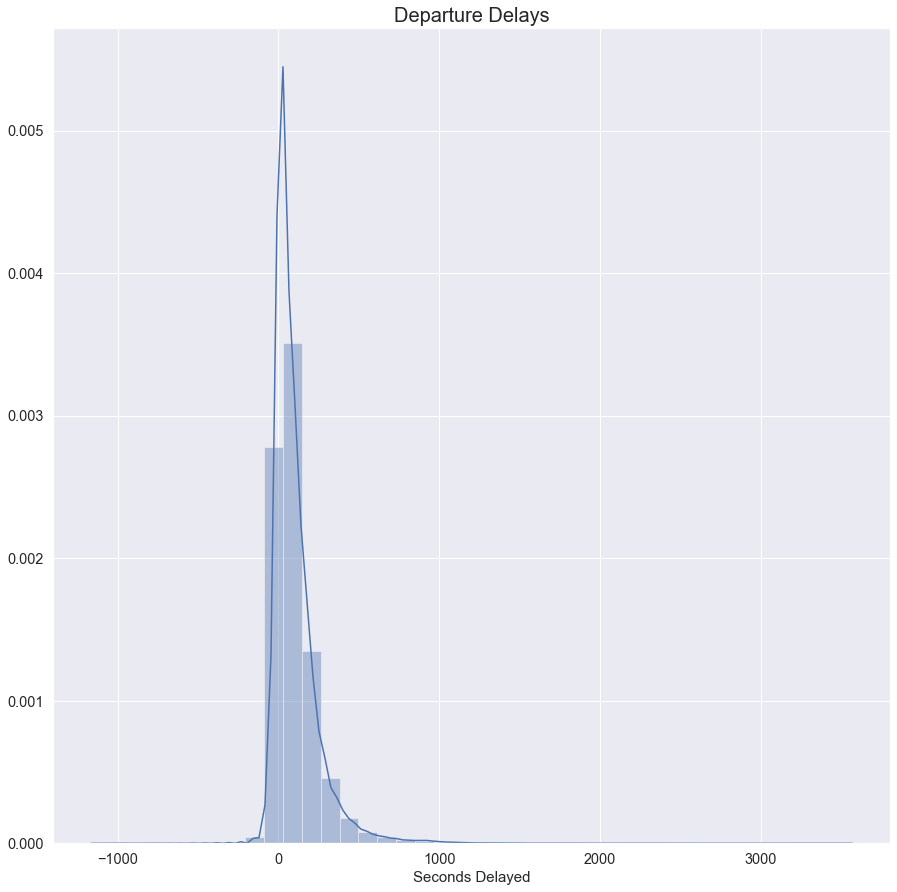

,branch,avg_seconds_delay
0,A,126.319735
1,B,53.951280
2,C,108.437090
3,D,124.783580
4,E,107.819996
5,F,159.647321
6,G,157.226133
7,H,133.359902
8,L,93.293571
9,R,59.330450


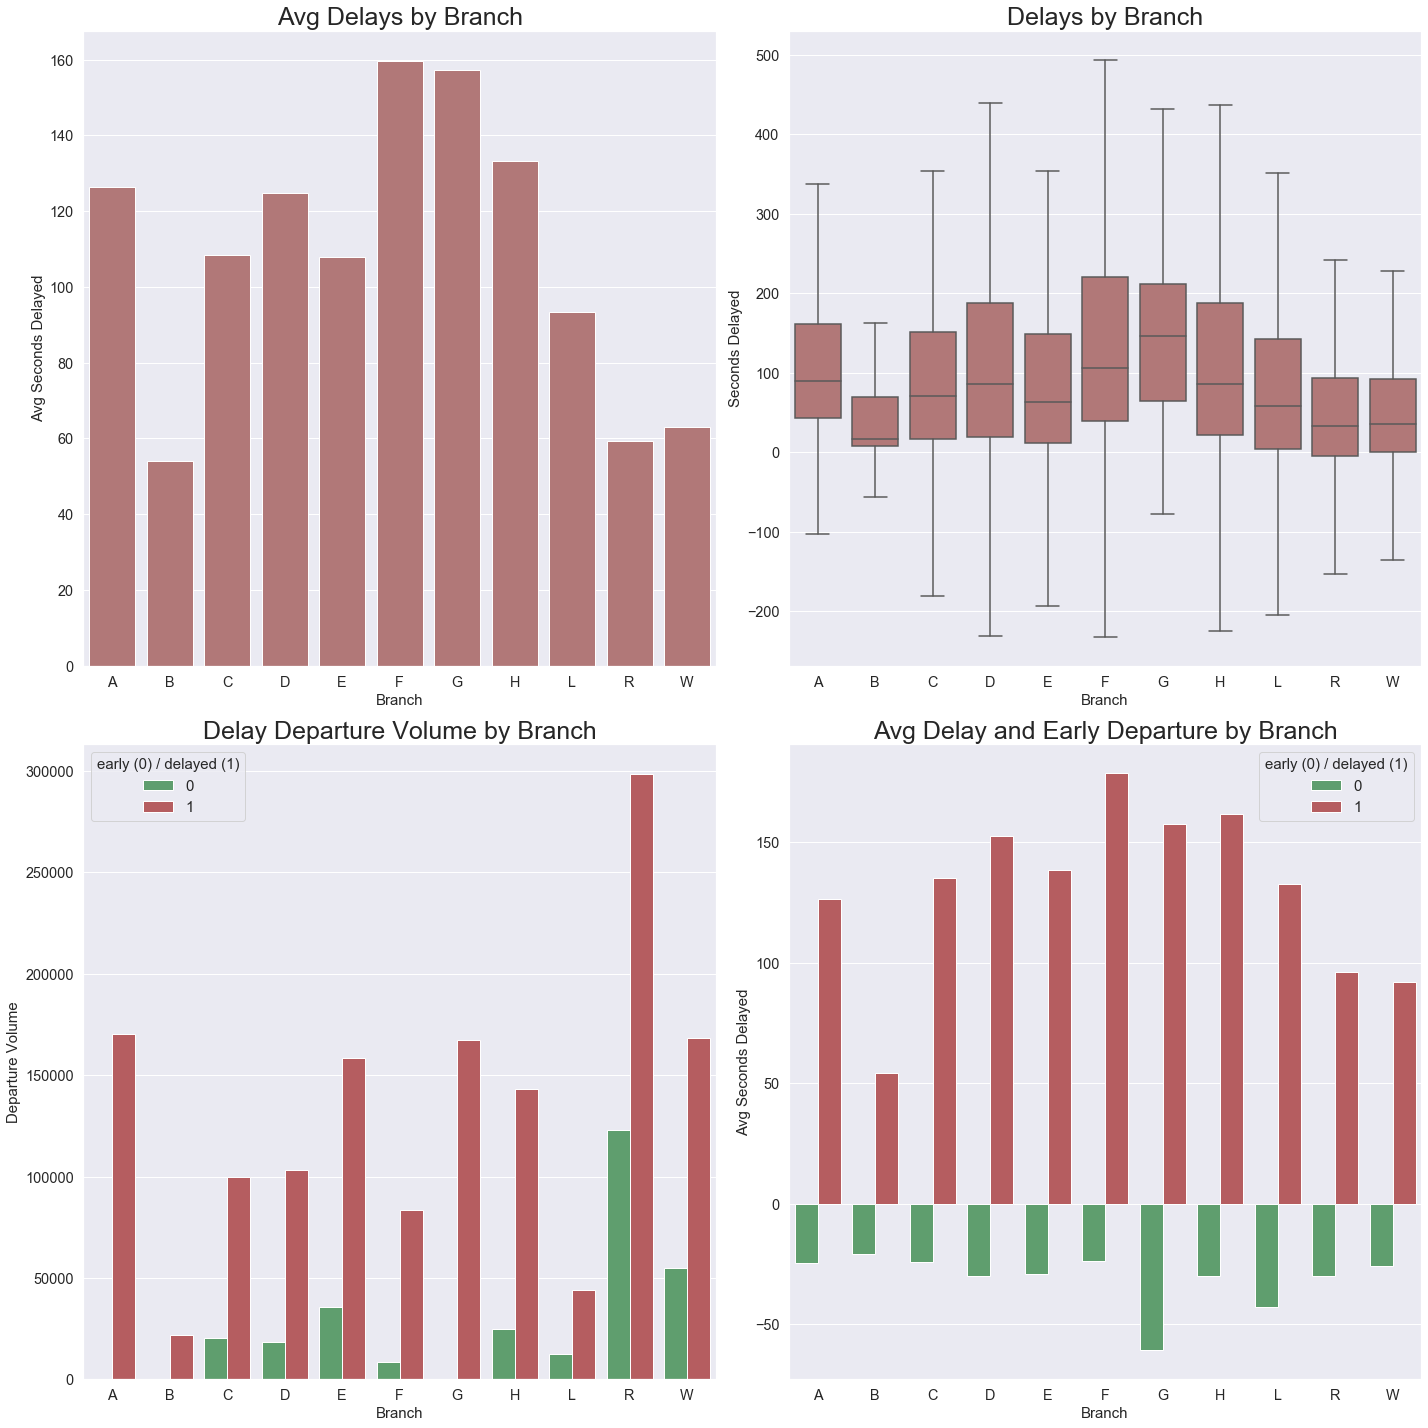

In [95]:
# Create smaller dataframe filtered to records that are not at the end of their respective line.
trains = trains_games[['DEPARTURE_DELAY',
                       'BRANCH',
                       'DIRECTION_NAME',
                       'DELAYED_FLG',  
                       'TIME_PERIOD',
                       'STOPNAME'
                      ]].loc[trains_games['END_OF_LINE'] == 0]

# Find average delayed departure.
total_mean = trains['DEPARTURE_DELAY'].mean()
print('Average seconds delay: ' + str(total_mean))
print('Percentage of delays over a minute late:',len(trains.loc[trains.DEPARTURE_DELAY>60]) / len(trains))

# View number of station departures that are late and early.
delay_pct = trains.DELAYED_FLG.value_counts(normalize=True, sort=False).mul(100)
delay_pct.index.name = 'delayed_departure'
delay_pct.name = 'percentage'
display(delay_pct.to_frame())

# Create histogram of DEPARTURE_DELAY.
plt.figure(figsize=(15,15))
sns.distplot(trains['DEPARTURE_DELAY'],
            bins = 40)
plt.xlabel('Seconds Delayed')
plt.title('Departure Delays')
plt.show()

# Average DEPARTURE_DELAY by BRANCH.
branch_mean_delay = trains[['BRANCH','DEPARTURE_DELAY']].groupby('BRANCH', as_index=False).mean()
branch_mean_delay.columns=['branch','avg_seconds_delay']
#branch_mean_delay.index.name = 'branch'
display(branch_mean_delay)


# Show average DEPARTURE_DELAY by BRANCH barchart visualization.
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
sns.barplot(x='branch',
             y='avg_seconds_delay',
             data = branch_mean_delay,
             color='indianred',
             saturation = 0.5)
plt.ylabel('Avg Seconds Delayed')
plt.title('Avg Delays by Branch',size=25)
plt.xlabel('Branch')


# Show BOXPLOT view of delayed departures by branch.
plt.subplot(2,2,2)
sns.boxplot(x='BRANCH',
             y='DEPARTURE_DELAY',
             data = trains.sort_values('BRANCH'),
             showfliers=False,
             color='indianred',
             saturation = 0.5)
plt.ylabel('Seconds Delayed')
plt.xlabel('Branch')
plt.title('Delays by Branch',size=25)

# Compare volume of delayed and on-time/early departures by BRANCH
plt.subplot(2,2,3)
sns.countplot(x='BRANCH',
             data=trains.sort_values('BRANCH'),
             hue='DELAYED_FLG', 
             palette={1:'r',
                     0:'g'})
plt.xlabel('Branch')
plt.ylabel('Departure Volume')
plt.title('Delay Departure Volume by Branch',size=25)
plt.legend(title='early (0) / delayed (1)')

# Compare average number of seconds early and delayed by BRANCH
early_late_delay = trains[['BRANCH','DEPARTURE_DELAY','DELAYED_FLG']].groupby(['BRANCH','DELAYED_FLG'],as_index=False).mean()
early_late_delay.columns=['branch','delayed_flg','avg_seconds_delay']
early_late_delay.sort_values('branch',inplace=True)
#early_late_delay.delayed_flg = early_late_delay.delayed_flg.map({1:'late',0:'early'})
plt.subplot(2,2,4)
sns.barplot(x='branch',
           y='avg_seconds_delay',
           hue='delayed_flg',
           data=early_late_delay,
           palette={1:'r',
                     0:'g'}
           )
plt.xlabel('Branch')
plt.ylabel('Avg Seconds Delayed')
plt.title('Avg Delay and Early Departure by Branch',size=25)
plt.legend(title='early (0) / delayed (1)')
plt.tight_layout()
plt.show()

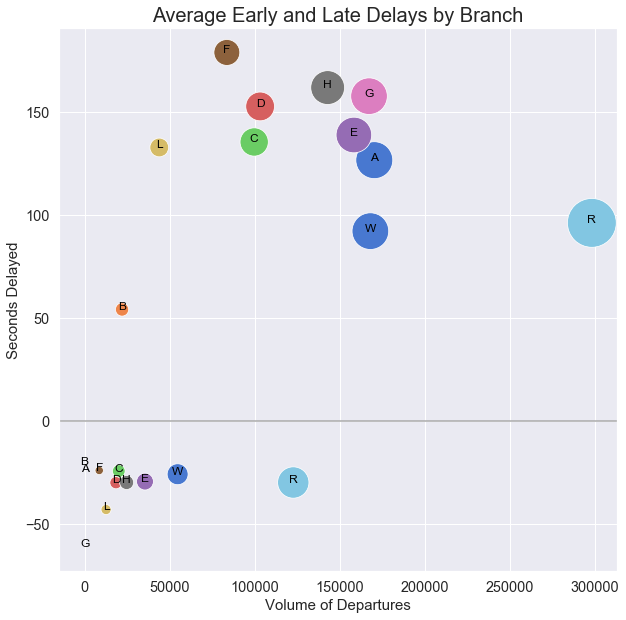

F_onewayResult(statistic=11347.65582125348, pvalue=0.0)


In [96]:
# Scatterplot view of average delay and volume of delays by branch and early/late departure
branch_mean_size_delay = trains[['BRANCH','DEPARTURE_DELAY','DELAYED_FLG']].groupby(by=['BRANCH','DELAYED_FLG']).agg({'DEPARTURE_DELAY':['count','mean']}).reset_index()
branch_mean_size_delay.columns = branch_mean_size_delay.columns.get_level_values(0)
branch_mean_size_delay.columns=['BRANCH','DELAYED_FLG','VOLUME','DEPARTURE_DELAY']
#display(branch_mean_size_delay)

plt.figure(figsize=(10,10))
ax = sns.scatterplot(x='VOLUME',
                   y='DEPARTURE_DELAY',
                   data=branch_mean_size_delay,
                   hue='BRANCH',
                    s=branch_mean_size_delay.VOLUME*.008,
                   legend=False,
                    marker='o',
                    palette='muted')
for line in range(0,branch_mean_size_delay.shape[0]):
     ax.text(branch_mean_size_delay.VOLUME[line], branch_mean_size_delay.DEPARTURE_DELAY[line], branch_mean_size_delay.BRANCH[line], horizontalalignment='center', size='medium', color='black')
plt.ylabel('Seconds Delayed')
plt.title('Average Early and Late Delays by Branch')
plt.xlabel('Volume of Departures')
plt.axhline(y=0, color='darkgray')
plt.show()

BRANCHES = list(trains.BRANCH.unique())

# Evaluate difference in mean among the various branches
print(stats.f_oneway(trains['DEPARTURE_DELAY'][trains['BRANCH'] == BRANCHES[0]],
                     trains['DEPARTURE_DELAY'][trains['BRANCH'] == BRANCHES[1]],
                     trains['DEPARTURE_DELAY'][trains['BRANCH'] == BRANCHES[2]],
                     trains['DEPARTURE_DELAY'][trains['BRANCH'] == BRANCHES[3]],
                     trains['DEPARTURE_DELAY'][trains['BRANCH'] == BRANCHES[4]],
                     trains['DEPARTURE_DELAY'][trains['BRANCH'] == BRANCHES[5]],
                     trains['DEPARTURE_DELAY'][trains['BRANCH'] == BRANCHES[6]],
                     trains['DEPARTURE_DELAY'][trains['BRANCH'] == BRANCHES[7]],
                     trains['DEPARTURE_DELAY'][trains['BRANCH'] == BRANCHES[8]],
                     trains['DEPARTURE_DELAY'][trains['BRANCH'] == BRANCHES[9]],
                     trains['DEPARTURE_DELAY'][trains['BRANCH'] == BRANCHES[10]]))

# Explore Possible Impact of Seasonaility and its Effect on Delays

To understand if the time of year has an effect on departure delays, time trended views from December 2018 through November 2019 are visualized below. Visualizations consider monthly averages as well as estimated rolling weekly, monthly, and quarterly averages.

,TIME,avg_delay
0,2018-12,73.212796
1,2019-01,76.491788
2,2019-02,99.263009
3,2019-03,116.974096
4,2019-04,93.786908
5,2019-05,111.386843
6,2019-06,89.750849
7,2019-07,98.859543
8,2019-08,111.797311
9,2019-09,109.725774


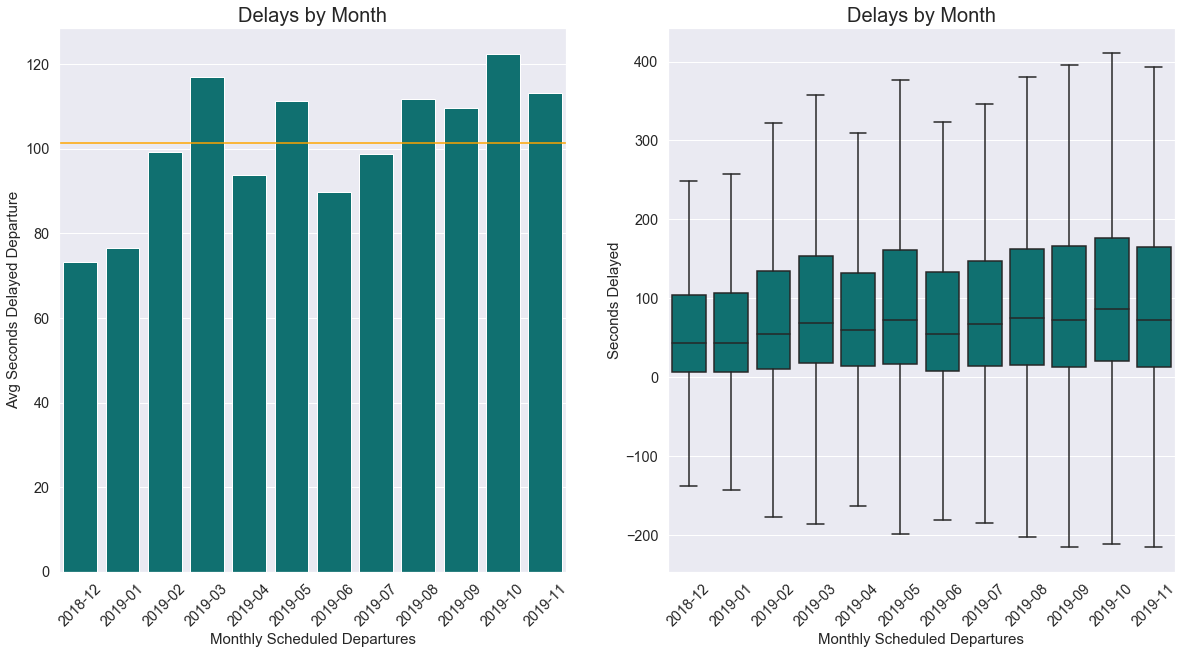

There are approximately 33775 station instances per week in this dataset.


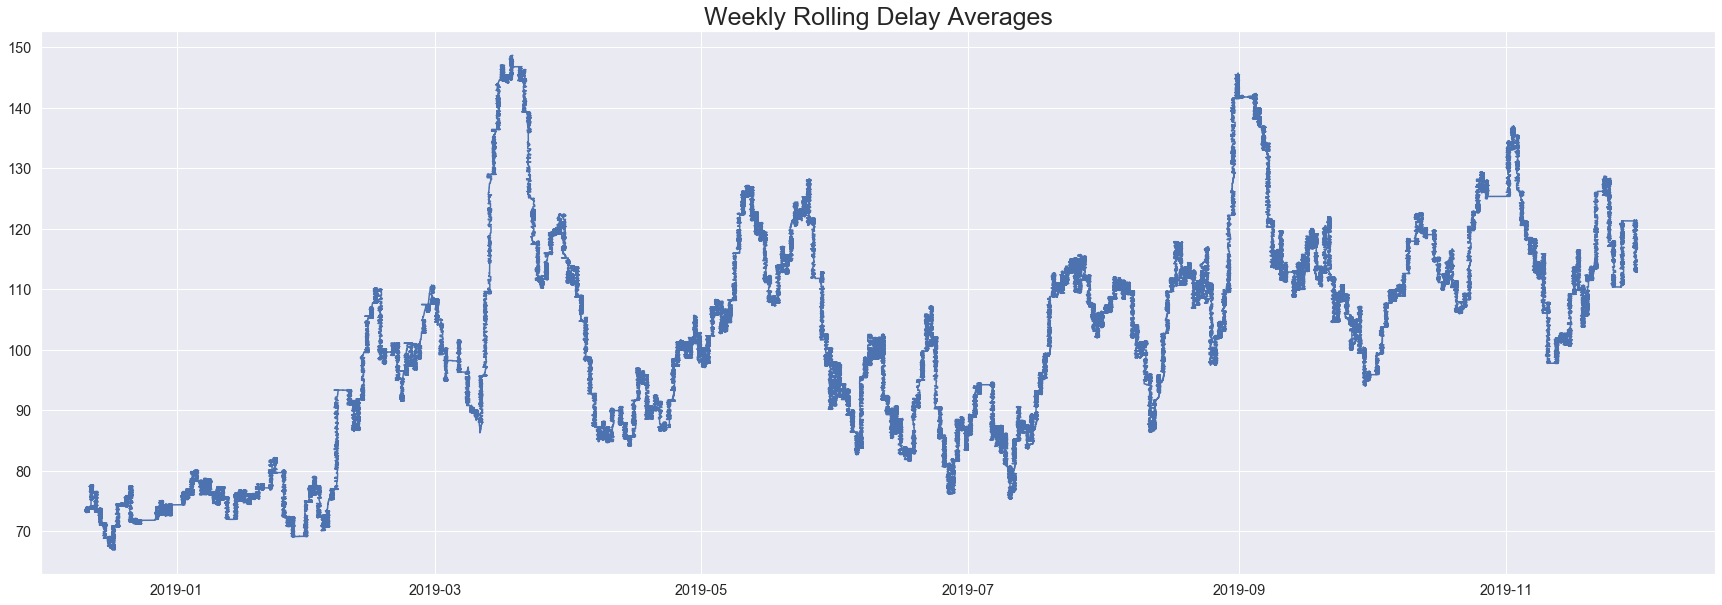

There are approximately 146359 station instances per month in this dataset.


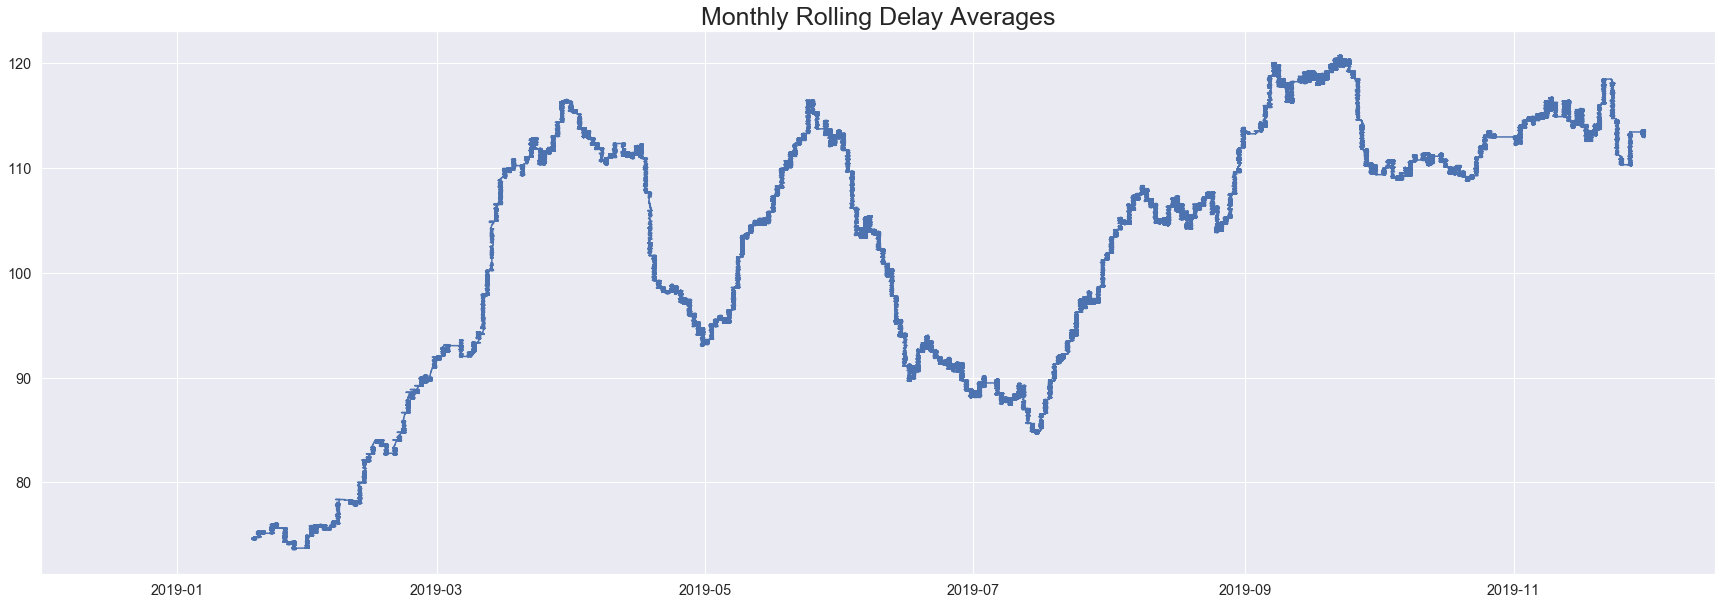

There are approximately 439079 station instances per month in this dataset.


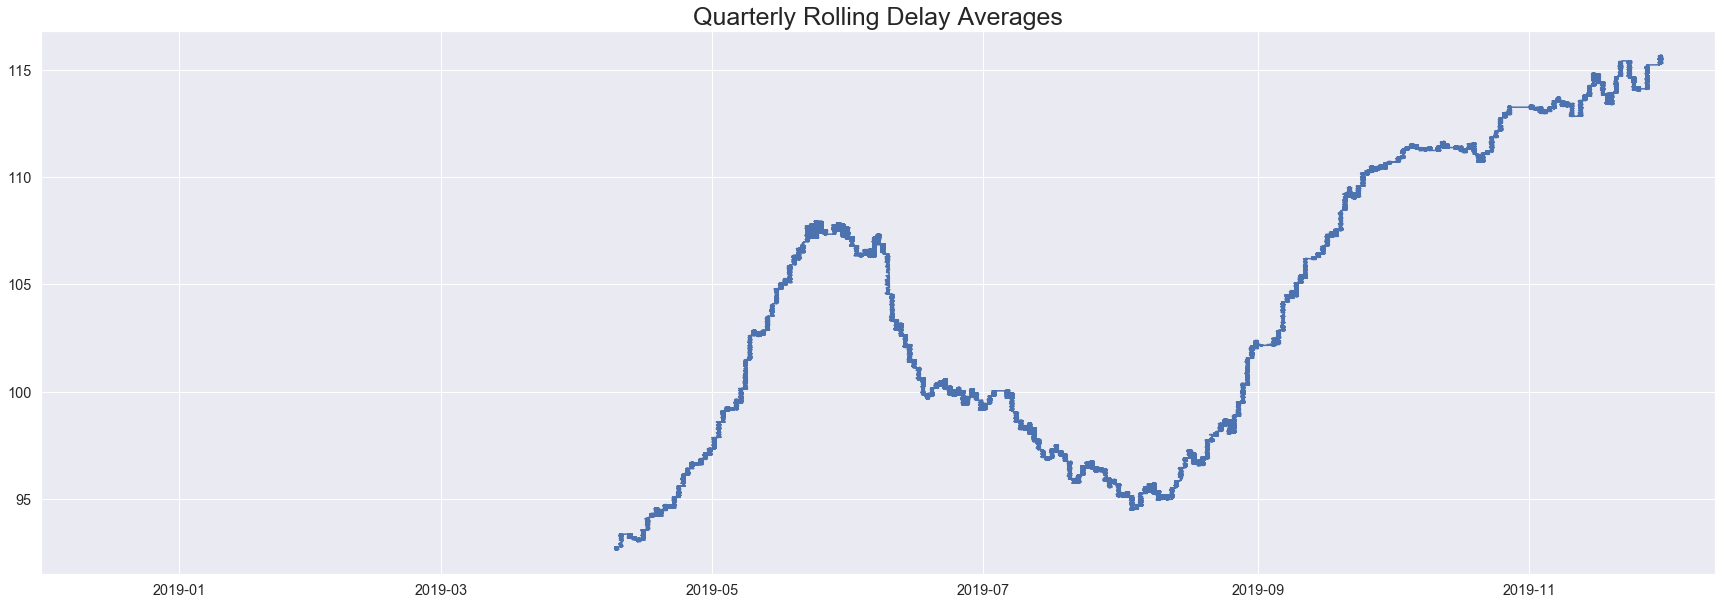

In [97]:
# Reduce to smaller dataframe fitlered on stations not at the end of their line.
monthly_delays = trains_games[['TIME_SCHEDULED',
                               'DEPARTURE_DELAY']].loc[trains_games['END_OF_LINE']==0]
# Calculate average minutes delay per discrete month.
monthly_delays.loc[:,'MONTH'] = monthly_delays.TIME_SCHEDULED.dt.month
monthly_delays.loc[:,'YEAR'] = monthly_delays.TIME_SCHEDULED.dt.year
monthly_delays.loc[:,'TIME'] = pd.to_datetime(monthly_delays['YEAR'].astype(str) + monthly_delays['MONTH'].astype(str), format = '%Y%m')
monthly_delays.loc[:,'TIME'] = monthly_delays.TIME.dt.to_period('M')
monthly_delays = monthly_delays[['TIME','DEPARTURE_DELAY']].groupby('TIME',as_index=False).mean()
monthly_delays.columns=['TIME','avg_delay']

display(monthly_delays)
total_avg = monthly_delays.avg_delay.mean()
monthly_delays['total_avg'] = total_avg

# Plot the discrete monthly averages.
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
_ = sns.barplot(x='TIME', y='avg_delay', data=monthly_delays,
           color='teal')
plt.xlabel('Monthly Scheduled Departures')
plt.ylabel('Avg Seconds Delayed Departure')
plt.title('Delays by Month')
plt.xticks(rotation=45)
plt.axhline(total_avg,
           color='orange')

plt.subplot(1,2,2)
_ = sns.boxplot(x=trains_games.TIME_SCHEDULED.dt.to_period('M').loc[trains_games['END_OF_LINE']==0],
               y='DEPARTURE_DELAY',
               color='teal',
               data=trains_games,
               showfliers=False)
plt.xlabel('Monthly Scheduled Departures')
plt.ylabel('Seconds Delayed')
plt.title('Delays by Month')
plt.xticks(rotation=45)
plt.show()

# Create new dataframe for rolling average measurements.
rolling_delays = trains_games[['TIME_SCHEDULED',
                               'DEPARTURE_DELAY']].loc[trains_games['END_OF_LINE']==0]
# Set variable to capture a fixed minimum x axis value to ensure all charts start at same point.
x_min = rolling_delays.TIME_SCHEDULED.min()

# Obtain number of records, i.e. stations, per incremental units to view rolling averages.
row_count = rolling_delays.shape[0]

# Calculate an estimated weekly rolling averages
print('There are approximately ' + str(int(row_count/52)) + ' station instances per week in this dataset.')
rolling_dep_weekly = rolling_delays.DEPARTURE_DELAY.rolling(window=35446).mean()

# Plot weekly rolling average.
plt.figure(figsize=(30,10))
plt.plot(rolling_delays.TIME_SCHEDULED, 
         rolling_dep_weekly)
plt.title('Weekly Rolling Delay Averages',size=25)
x1,x2,y1,y2 = plt.axis()
plt.axis((x_min,x2,y1,y2))
plt.show()

# Calculate an estimated monthly rolling averages
print('There are approximately ' + str(int(row_count/12)) + ' station instances per month in this dataset.')
rolling_dep_weekly = rolling_delays.DEPARTURE_DELAY.rolling(window=153602).mean()

# Plot weekly rolling average.
plt.figure(figsize=(30,10))
plt.plot(rolling_delays.TIME_SCHEDULED, 
         rolling_dep_weekly)
plt.title('Monthly Rolling Delay Averages',size=25)
x1,x2,y1,y2 = plt.axis()
plt.axis((x_min,x2,y1,y2))
plt.show()

# Calculate an estimated quarterly rolling averages
print('There are approximately ' + str(int(row_count/4)) + ' station instances per month in this dataset.')
rolling_dep_weekly = rolling_delays.DEPARTURE_DELAY.rolling(window=460808).mean()
# Plot weekly rolling average.
plt.figure(figsize=(30,10))
plt.plot(rolling_delays.TIME_SCHEDULED, 
         rolling_dep_weekly)
plt.title('Quarterly Rolling Delay Averages',size=25)
x1,x2,y1,y2 = plt.axis()
plt.axis((x_min,x2,y1,y2))
plt.show()

While it's difficult to identify seasonality trends with a single year, there is are higher than average departure delays in August through November of 2019 that may correspond to more recent driver shortages at RTD. There is also a steady increase in the average departure delay from January to March that may correspond to impacts from winter weather.

# Explore Performance Further by Direction, Branch, Station

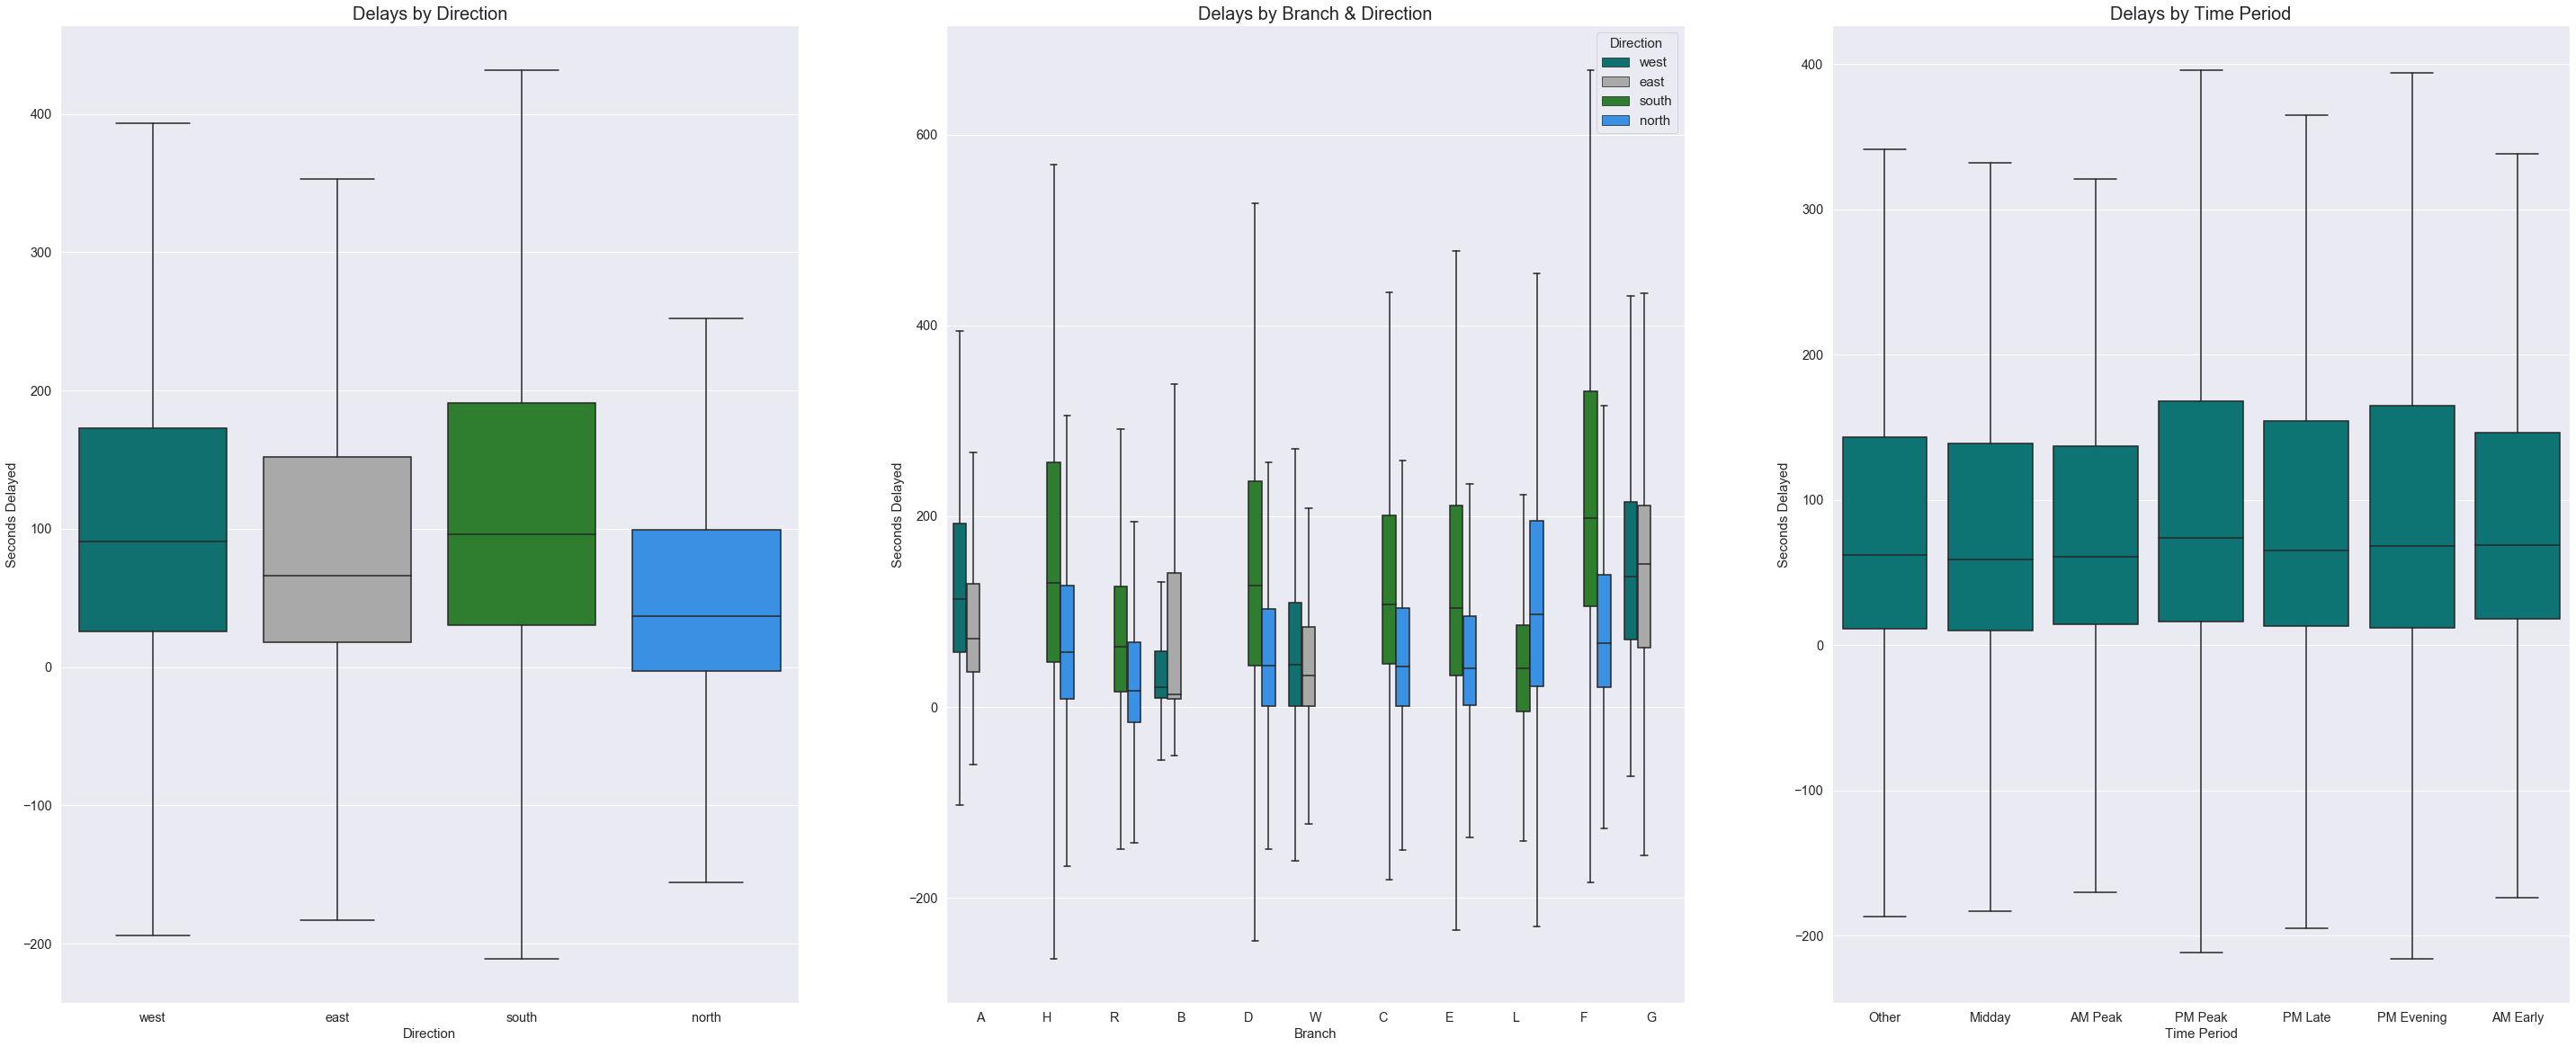

Station Departure Delay Variance: DEPARTURE_DELAY    4010.278762
dtype: float64


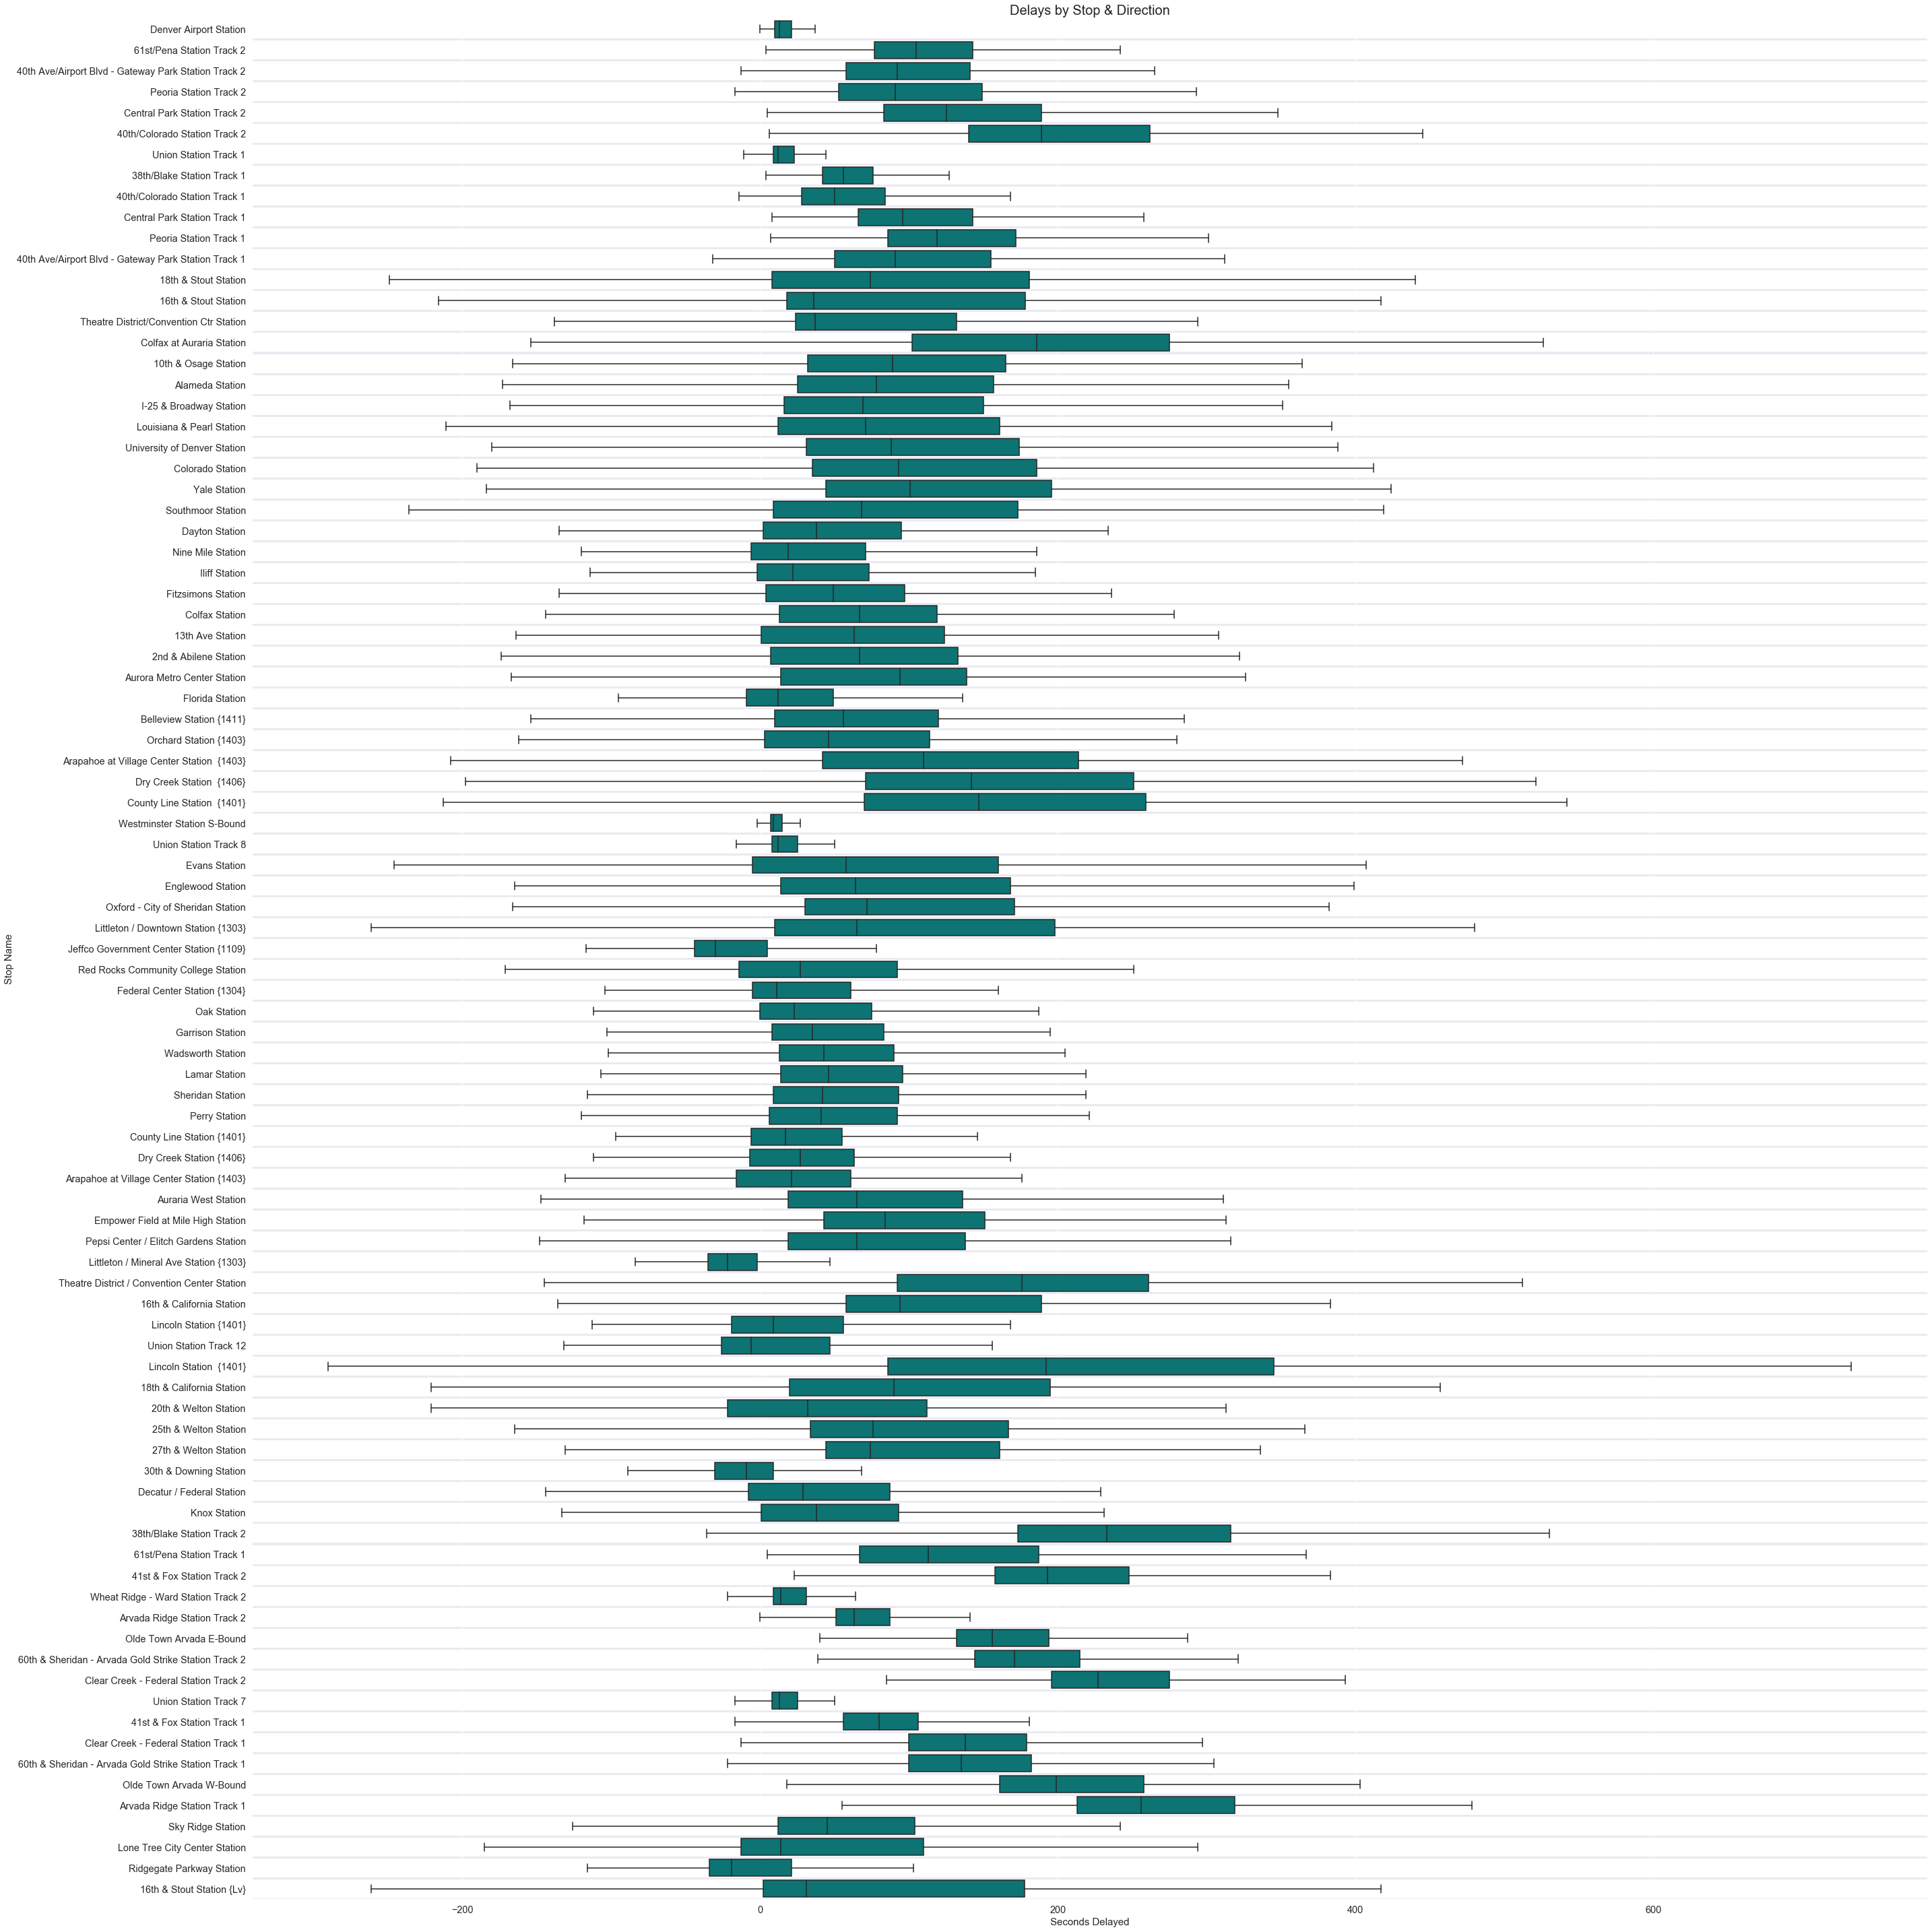

In [99]:
# Plot departure delays by DIRECTION_NAME.
direction_pal = {'west':'teal' ,
                'east': 'darkgray',
                'north': 'dodgerblue',
                'south': 'forestgreen'}
plt.figure(figsize=(50,20))
plt.subplot(1,3,1)
# Plot delay by direction
sns.boxplot(x='DIRECTION_NAME',
             y='DEPARTURE_DELAY',
             data = trains,
             showfliers=False,
             palette=direction_pal)
plt.ylabel('Seconds Delayed')
plt.xlabel('Direction')
plt.title('Delays by Direction')

# Plot departure delays by BRANCH and DIRECTION_NAME removing outliers.
plt.subplot(1,3,2)
sns.boxplot(x='BRANCH',
             y='DEPARTURE_DELAY',
             palette=direction_pal,
             hue = 'DIRECTION_NAME',
             data = trains,
             showfliers=False)
plt.ylabel('Seconds Delayed')
plt.xlabel('Branch')
plt.title('Delays by Branch & Direction')
plt.legend(title='Direction')

# Plot delay by TIME_PERIOD.
plt.subplot(1,3,3)
sns.boxplot(x='TIME_PERIOD',
             y='DEPARTURE_DELAY',
             data = trains,
             showfliers=False,
             color='teal',
             saturation=0.8)
plt.ylabel('Seconds Delayed')
plt.xlabel('Time Period')
plt.title('Delays by Time Period')
plt.show()

# Plot delay by STOPNAME.
plt.figure(figsize=(40,40))
station_delays_bplot = sns.boxplot(y='STOPNAME',
             x='DEPARTURE_DELAY',
             data = trains,
             color='teal',
             saturation=0.8,
             orient ="h",
             showfliers=False)
station_delays_bplot.yaxis.grid(True, linewidth=28)
plt.ylabel('Stop Name')
plt.xlabel('Seconds Delayed')
plt.title('Delays by Stop & Direction')
print("Station Departure Delay Variance: "+str(trains[['DEPARTURE_DELAY','STOPNAME']].groupby('STOPNAME').mean().var()))


plt.tight_layout()
plt.show()

Evaluation of the above shows a couple of areas of interest. First and foremost, south bound trains experience worse delays than the other 3 directions. Additionally, there is a large variety of performance by station, as shown immediately above.

# Explore Possible Impact of Prior Delays on Current Delay

The function below produces the correlation between a train's prior delay (noted by shift) on the current delay. For example, it can produce the correlation between the departure delay 3 station's ago
as compared to the current station. Interestingly, the linear correlation (noted by Pearson r value) seems to decline as one moves further back into prior stations. This seems to indicate that lines
may be making up for prior delays as the line progresses.

In [100]:
def prior_delay(df,shift_value):
    """
       Returns dataframe and correlation of previous (n) station's delay and current delay.
    
       Parameters:
       df: train station data that must include SERIAL_NUMBER, TIME_SCHEDULED, DEPARTURE_DELAY, and END_OF_LINE
       shift_value: represents n stations in past
    
    """  
    # Sort values by serial number and time scheduled and reset index
    df = df.sort_values(by=['SERIAL_NUMBER','TIME_SCHEDULED'])
    df.reset_index(inplace=True)
    
    # Create a smaller dataframe with delay and matching fields
    df_shifted = df[['SERIAL_NUMBER','DEPARTURE_DELAY']].shift(shift_value)
    
    # Create a new field to capture the prior n delay
    new_field = 'prior_departure_delay'+'_'+str(shift_value)
    df_shifted.columns=['SERIAL_NUMBER',new_field]
      
    # Merge the reduced dataframe into the master matching indeces and ensuring serial numbers match
    df = pd.merge(df,
                 df_shifted,
                 #on='SERIAL_NUMBER',
                 left_index=True,
                 right_index=True,
                 how='left')
    
    # Replace NaN fields with 0 as previous delays at non-existent trains would effectively be 0
    df[new_field].fillna(0, inplace=True)
    
    # Iterate over rows to identify prior delays pulled from mismatched serial number
    for index, row in df.iterrows():
        prior_index = index - shift_value
        if prior_index >=0:
            if row['SERIAL_NUMBER_x'] != df.at[prior_index, 'SERIAL_NUMBER_x']:
                df.at[index,new_field] = 0
    
    # Drop the extraneous SERIAL_NUMBER FIELD and set original SERIAL_NUMBER to original format
    df = df.drop(['SERIAL_NUMBER_y'], axis=1)
    df = df.rename(columns={'SERIAL_NUMBER_x':'SERIAL_NUMBER'})
    df =  df[df.columns.drop(list(df.filter(regex='index')))]
    df =  df[df.columns.drop(list(df.filter(regex='level')))]
    
    
    return stats.pearsonr(df.iloc[:,1],df.iloc[:,-1])[0]

In [101]:
# Create dictionary of correlations of prior delays and current delay
prior_delay_corr = {}
for n in np.arange(1,11,1):
    prior_delay_corr[-n] = prior_delay(trains_games[['TIME_SCHEDULED','DEPARTURE_DELAY','SERIAL_NUMBER']].loc[trains_games['END_OF_LINE']==0],shift_value=n)
print(prior_delay_corr)

{-1: 0.9295580308867835, -2: 0.8676207023293948, -3: 0.8111825917964988, -4: 0.7473234457096944, -5: 0.6786601277262985, -6: 0.614358602352634, -7: 0.5598730170786407, -8: 0.5110544300352957, -9: 0.46203994715849855, -10: 0.4163900860910016}


In [102]:
# Average number of trains per specific route
trains_games['SERIAL_NUMBER'].value_counts().mean()

12.286039874614856

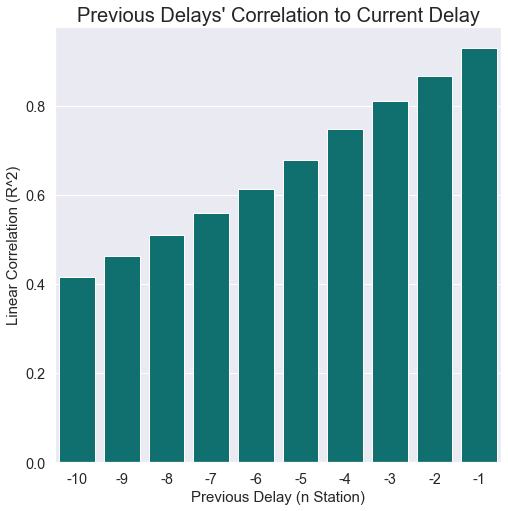

In [103]:
# Plot correlations of prior delays and current delay
station = []
correlation = []
for key, values in prior_delay_corr.items():
    station.append(key)
    correlation.append(values)
plt.figure(figsize=(8,8))
_ = sns.barplot(x=station,
               y=correlation,
               color='teal')
plt.title("Previous Delays' Correlation to Current Delay")
plt.ylabel('Linear Correlation (R^2)')
plt.xlabel('Previous Delay (n Station)')
plt.show()

# Explore Possible Impact of Local Sport Events on Delays

The function below compares departure delays on days wherein a selected sport team played a game with those days wherein the team did not host a game. As the figures seem to indicate, the presence of Rockies, Avalanche, Nuggets, or Broncos games on the same calendar day does not seem to skew the typical departure delays significantly. However, comparing Broncos game days with exclusively Sundays seems to show train delays are lower than typical Sundays on days in which the Broncos play.

In [104]:
def game_comparison(df, delay, team):
    """Function compares delays on game day with non-game days of selected team.
    
    Paramters:
       df: train station data that must include sport team data and (derived) DEPARTURE_DELAY
       team: user selection that should be Rockies, Avalanche, Nuggets, or Broncos.
    
    Value specified for team will be capitalized and respective date of game will be used for delay comparisons"""
    team = team.capitalize()
    if team in ('Rockies','Rox'):
        team_field = 'Rox_Date'
    elif team in ('Avalanche','Avs'):
        team_field = 'Avs_Date'
    elif team in ('Nuggets','Nugs'):
        team_field = 'Nuggets_Date'
    elif team in ('Broncos'):
        team_field = 'Broncos_Date'
    else:
        print("Specify a different team parameter. Select Rockies, Avalanche, Nuggets, or Broncos.")
    new_df = []
    new_df = df[[delay,team_field]].loc[trains_games['END_OF_LINE']==0]   
    game_day_idx = new_df.loc[new_df[team_field].notnull()].index
    new_df['game'] = 'no game'
    new_df.loc[game_day_idx,'game'] = 'game day'
    
    """Game day comparison plotted"""
    plt.figure(figsize=(8,8)) 
    sns.boxplot(x='game',
             y=delay,
             data = new_df,
             showfliers=False,
             color='indianred',
             saturation=0.8)
    plt.ylabel('Seconds Delayed')
    plt.title(team + ' Game Day Effect on Delay')
    plt.show()
    display(new_df.groupby('game').describe())
    

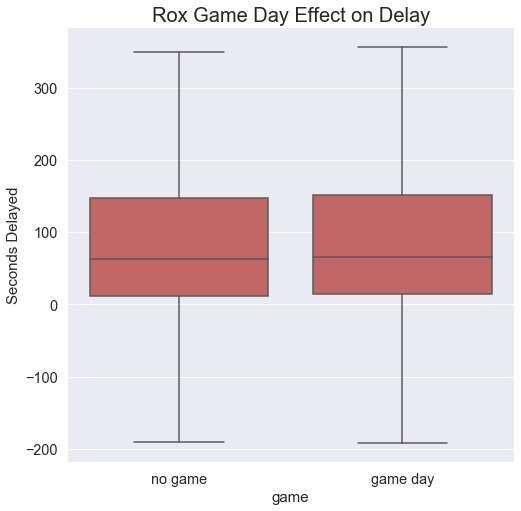

DEPARTURE_DELAY                                                     \
                   count        mean         std     min   25%   50%    75%   
game                                                                          
game day        476954.0  102.316651  140.905004  -658.0  14.0  66.0  151.0   
no game        1279365.0  102.237592  149.837803 -1146.0  12.0  63.0  147.0   

                  
             max  
game              
game day  3517.0  
no game   3550.0

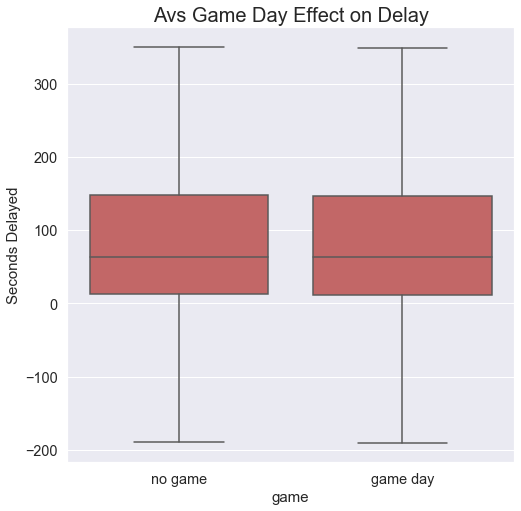

DEPARTURE_DELAY                                                     \
                   count        mean         std     min   25%   50%    75%   
game                                                                          
game day        170358.0  102.273037  150.455986 -1146.0  12.0  63.0  147.0   
no game        1585961.0  102.257561  147.140668  -808.0  13.0  64.0  148.0   

                  
             max  
game              
game day  3550.0  
no game   3517.0

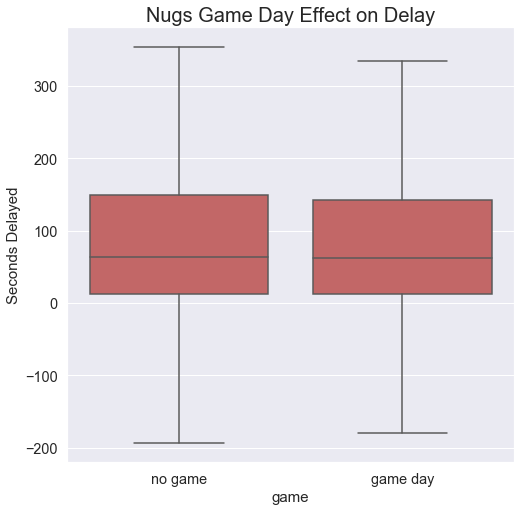

DEPARTURE_DELAY                                                     \
                   count        mean         std     min   25%   50%    75%   
game                                                                          
game day        201842.0  101.098835  147.538965  -592.0  13.0  62.0  142.0   
no game        1554477.0  102.409712  147.455297 -1146.0  12.0  64.0  149.0   

                  
             max  
game              
game day  3517.0  
no game   3550.0

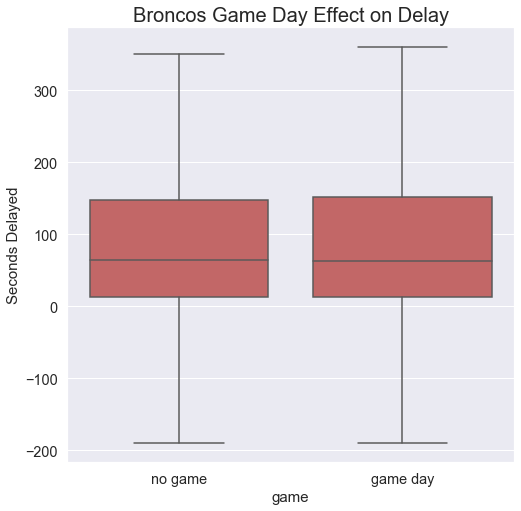

DEPARTURE_DELAY                                                     \
                   count        mean         std     min   25%   50%    75%   
game                                                                          
game day         25885.0  101.594630  138.990531  -588.0  13.0  63.0  152.0   
no game        1730434.0  102.269001  147.588560 -1146.0  13.0  64.0  148.0   

                  
             max  
game              
game day  1471.0  
no game   3550.0

In [105]:
game_comparison(trains_games, 'DEPARTURE_DELAY', 'Rox')
game_comparison(trains_games, 'DEPARTURE_DELAY', 'Avs')
game_comparison(trains_games, 'DEPARTURE_DELAY', 'Nugs')
game_comparison(trains_games, 'DEPARTURE_DELAY', 'Broncos')

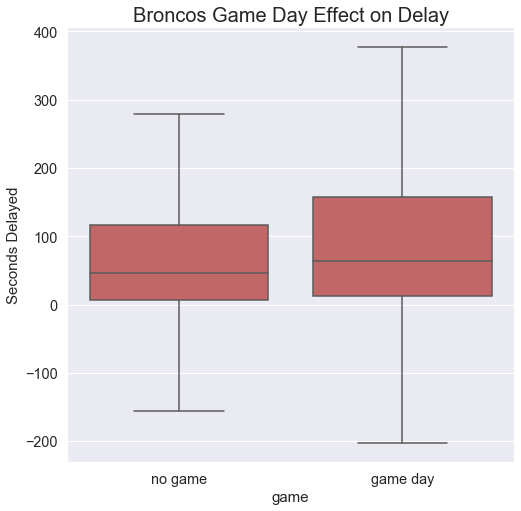

DEPARTURE_DELAY                                                    \
                   count        mean         std    min   25%   50%    75%   
game                                                                         
game day         19380.0  102.723478  139.928453 -588.0  12.0  64.0  158.0   
no game         205993.0   76.428141  120.243350 -808.0   7.0  46.0  116.0   

                  
             max  
game              
game day  1242.0  
no game   2485.0

In [106]:
# Isolating Sundays to identify affect on delays when a Broncos game occurs
sunday_trains = trains_games.loc[trains_games.SERVICE_PERIOD=='Sunday']
game_comparison(sunday_trains, 'DEPARTURE_DELAY', 'Broncos')

# Explore Possible Impacts to Delays by Proximity to Broncos Game

Based on the above Broncos visuals the below function will map this performance in regards to Broncos kickoff time in hours. However, the Model Creation ipython noteboook provides a cleaner representation of this analysis for all teams.

In [107]:
# Create a full datetime object indicating Broncos kickoff time.
trains_games['BRONCOS_TIME'] = pd.to_datetime(trains_games['Broncos_Date'].dt.strftime('%Y-%m-%d') + ' ' + trains_games['Broncos_Time'].astype(str), errors='coerce')

In [108]:
def time_until_broncos(df):
    """Function evaluating if train delays fluctuate based on their proximity to the departure of trains.
    
    Paramters:
       -df: train station data that must include END_OF_LINE and BRONCOS_TIME configured as datetime type 
    """
    new_df = df[['DEPARTURE_DELAY','TIME_SCHEDULED','DEPARTURE','BRONCOS_TIME']].loc[(df.Broncos_Date.notnull()) & (df['END_OF_LINE']==0)]
    new_df['hours_until_game'] = (new_df['BRONCOS_TIME'] - new_df['TIME_SCHEDULED'])
    new_df['hours_until_game'] = new_df['hours_until_game']/np.timedelta64(1,'h')
    new_df['hours_until_game'] = new_df.hours_until_game.astype('int')
    new_df = new_df[['hours_until_game','DEPARTURE_DELAY']].groupby('hours_until_game',as_index=False).mean()
    plt.figure(figsize=(20,20))
    sns.lineplot(x='hours_until_game',
               y='DEPARTURE_DELAY',
               data=new_df)
    plt.xlabel('Delay by Hours Until Broncos Game')
    plt.ylabel('Avg Seconds Delay')
    plt.title('Hours Until Broncos Game')
    plt.show()

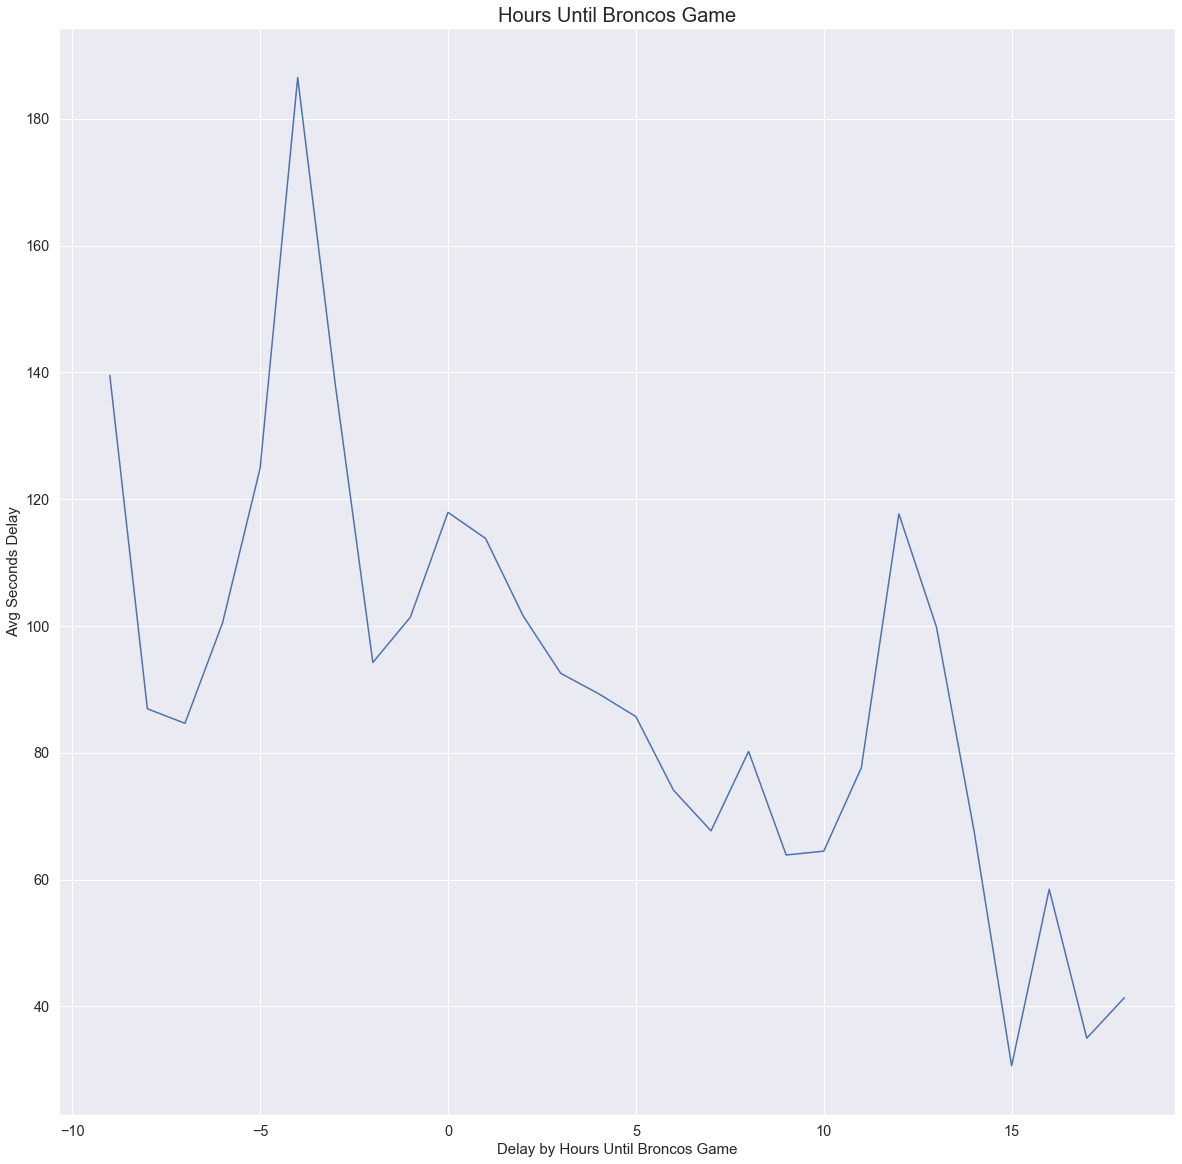

In [109]:
# Plot DEPARTURE_DELAY by proximity to Broncos kickoff in hours.
time_until_broncos(trains_games)


The above trend in departure delay seems to indicate 2 peaks occuring around 3 hours before kickoff and 13 hours after kickoff. The first spike could very well coincide with Broncos foot traffic and could be investigated further. However, the 2nd spike will likely occur well after the close of the game and could very well coincide with Monday morning rush hour after Sunday games.

# Merge in Hourly Weather Data

The below section will feature the hourly weather data sourced from Visual Crossing (visualcrossing.com). Data was sourced by City. 

In [110]:
# Produce a csv of STOPNAME and CITY combinations to research the missing CITY values.
station_city = trains_games[['STOPNAME','CITY']].drop_duplicates()
pd.DataFrame(station_city).to_csv('station_city.csv',header=True,index=None)

In [111]:
# Create datafataframe from researched STOPNAME-CITY list for those originally missing CITY values.
station_city = '../station_city_researched.csv'
city_updates = pd.read_csv(station_city,
                       header=0,
                       sep=',')

In [112]:
# The native STOPNAME + CITY combinations in RTD data have duplicative STOPNAME rows with different CITY values. 
# Those STOPNAMES are 'Red Rocks Community College Station' and 'Sheridan Station'.
# These records will be updated and duplicates dropped prior to merge.

city_updates.loc[city_updates['STOPNAME']=='Red Rocks Community College Station', 'CITY'] = 'Lakewood'
city_updates.loc[city_updates['STOPNAME']=='Sheridan Station', 'CITY'] = 'Denver'
city_updates = city_updates.drop_duplicates()

In [113]:
# Merge the STOPNAME-CITY list in with the master dataframe, update the original CITY field, and drop the extra CITY_new field.
trains_games = trains_games.merge(city_updates[['STOPNAME','CITY']],
                                 how='left',
                                 on='STOPNAME',
                                 suffixes=('','_new'))
trains_games['CITY'] = trains_games['CITY_new']
trains_games = trains_games.drop('CITY_new', axis=1)

In [114]:
# Produce the unique list of CITY values for weather research.
display(trains_games.CITY.unique())

array(['Denver', 'Aurora', 'Greenwood Village', 'Centennial', 'Lone Tree',
       'Westminster', 'Englewood', 'Littleton', 'Golden', 'Lakewood',
       'Meridian', 'Wheat Ridge', 'Arvada'], dtype=object)

In [115]:
weather_list = glob.glob('../visual_crossings_weather/history_data*.csv')
weather_data = pd.DataFrame()
for city_weather in weather_list:
    weather_df = pd.read_csv(city_weather,
                            header=0,
                            sep=',',
                            date_parser=True,
                            infer_datetime_format =True,
                            keep_date_col =True
                            )
    if len(weather_data) == 0:
        weather_data = weather_df
    else:
        weather_data = weather_data.append(weather_df)

weather_data['Date'] = pd.to_datetime(weather_data['Date time'])
weather_data = weather_data.drop(['Latitude','Address','Resolved Address','id','Longitude','Name','Date time','Info'], axis=1)
weather_data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122318 entries, 0 to 8736
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Location             122318 non-null  object        
 1   Wind Direction       113506 non-null  float64       
 2   Cloud Cover          89971 non-null   float64       
 3   Minimum Temperature  122156 non-null  float64       
 4   Precipitation        888 non-null     float64       
 5   Dew Point            122126 non-null  float64       
 6   Relative Humidity    122156 non-null  float64       
 7   Precipitation Cover  5610 non-null    float64       
 8   Temperature          122156 non-null  float64       
 9   Maximum Temperature  122156 non-null  float64       
 10  Visibility           122085 non-null  float64       
 11  Wind Speed           115387 non-null  float64       
 12  Heat Index           9335 non-null    float64       
 13  Weather Type    

In [116]:
# Train (with local game) data will be merged with hourly weather data ensuring that the 
#       closest weather recording for the respective county is brought in, restricting the weather recording to not occuring after the departure of the train.
# Dataframes must first be sorted by matching datetime columns.
weather_data.rename(columns={'Location':'CITY'},inplace=True)
trains_games.sort_values('DEPARTURE',inplace=True)
weather_data.sort_values('Date',inplace=True)
train_master = pd.merge_asof(trains_games,
                                         weather_data,
                                         by='CITY',
                                         allow_exact_matches=True,
                                         left_on = 'DEPARTURE',
                                         right_on = 'Date',
                                         suffixes=('','_weather'),
                                         tolerance=pd.Timedelta('1 days'))

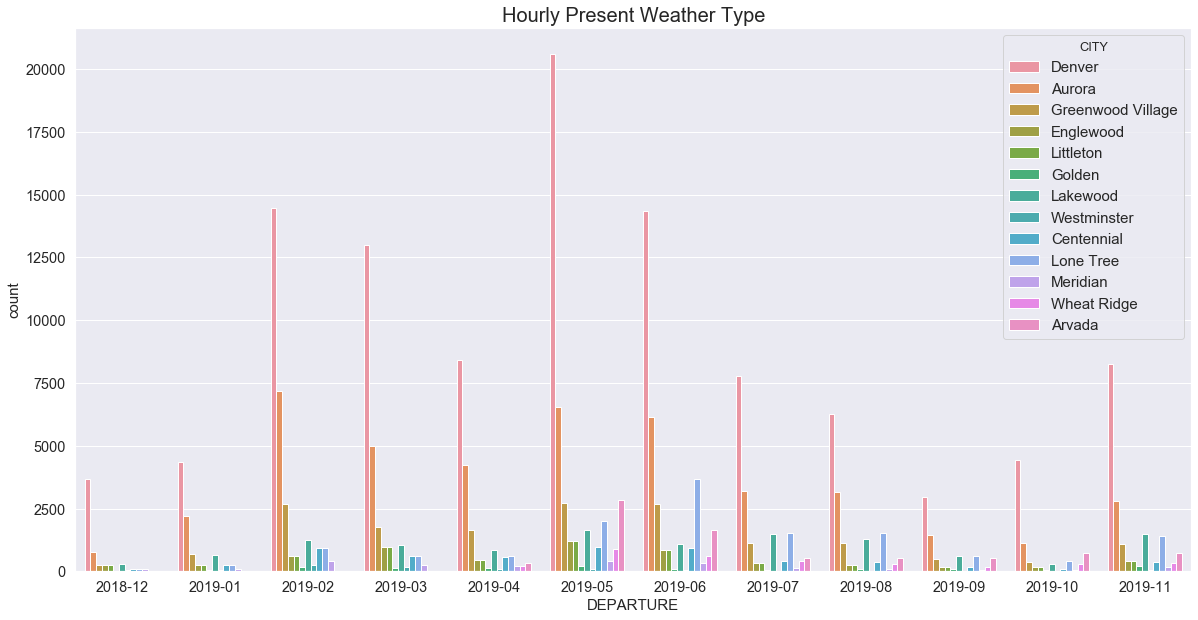

In [117]:
# Ensure Weather Type is commonplace across date range and CITY values.
weather_type_test = train_master[['DEPARTURE','CITY','Weather Type']].loc[train_master['Weather Type'].notnull()]
weather_type_test.reset_index(inplace=True)

# Plot spread of Weather Type.
plt.figure(figsize=(20,10))
sns.countplot(x=weather_type_test.DEPARTURE.dt.to_period('M').sort_values(),
            hue='CITY',
            data=weather_type_test)
plt.title('Hourly Present Weather Type')
plt.show()

In [118]:
# Identify unique descriptors in Weather Type beginning with splitting the value by the ',' delimeter.
weather_type_list = weather_data['Weather Type'].str.split(',',n=4, expand=True)

# Create a list of all descriptors, as they are in a variety of orders and lengths.
weather_set_1 = list(weather_type_list[0])
weather_set_2 = list(weather_type_list[1])
weather_set_3 = list(weather_type_list[2])
weather_set_4 = list(weather_type_list[3])
weather_set = weather_set_1 + weather_set_2 + weather_set_3 + weather_set_4

# Remove duplicative and null items.
weather_set = set(weather_set)
weather_set.remove(None)
weather_set.remove(np.nan)

# Strip out leading and trailing spaces.
weather_list = list(weather_set)
for idx in range(len(weather_list)):
    weather_list[idx] = weather_list[idx].strip()

# Once again create a unique listing of weather types.
new_weather_set = set(weather_list)
display(new_weather_set)

{'Blowing Or Drifting Snow',
 'Drizzle',
 'Fog',
 'Freezing Drizzle/Freezing Rain',
 'Hail Showers',
 'Heavy Drizzle',
 'Heavy Rain',
 'Heavy Snow',
 'Ice',
 'Light Drizzle',
 'Light Freezing Drizzle/Freezing Rain',
 'Light Freezing Rain',
 'Light Rain',
 'Light Rain And Snow',
 'Light Snow',
 'Lightning Without Thunder',
 'Mist',
 'Rain',
 'Rain Showers',
 'Smoke Or Haze',
 'Snow',
 'Thunderstorm'}

In [119]:
# Function to create unique fields for each part of the weather type description field. 
def weather_indicator(train_master, new_weather_set):
    for item in list(new_weather_set):
        train_master[item] = np.where(train_master['Weather Type'].str.contains(item, regex=False, case=False, na=False), 1, 0)
    return train_master


In [120]:
train_master = weather_indicator(train_master, new_weather_set)
train_master['no_weather_type'] = np.where(train_master['Weather Type'].isnull(), 1, 0)

In [121]:
# Function to compare the correlation between quantiative weather and delays.
# However, this function does not normalize inputs and is merely explorative. 
def weather_correlation(train_master, weather_field):
    df = train_master[[weather_field, 'DEPARTURE_DELAY']].loc[train_master['END_OF_LINE']==0]
    weather_corr = sns.jointplot(x=weather_field,
              y='DEPARTURE_DELAY',
              data=df,
              kind='reg',
              height=8).annotate(stats.pearsonr)
    plt.ylabel('Departure Delay')
    plt.xlabel(weather_field)
    plt.title('Impact of '+weather_field+' on Delays')
    plt.show()

C:\Users\jsummer\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


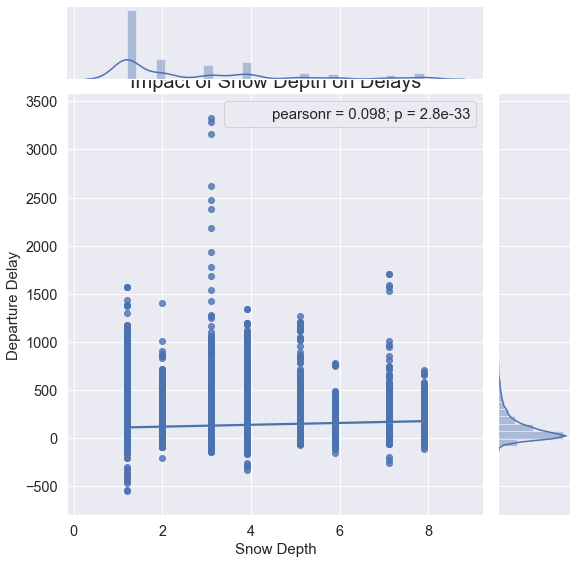

C:\Users\jsummer\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


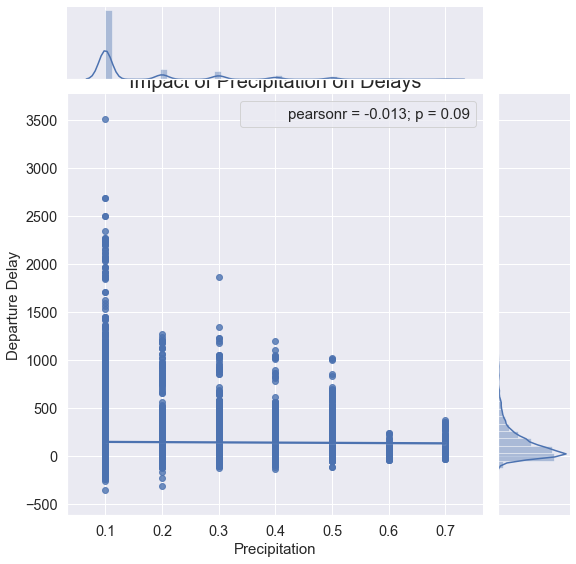

C:\Users\jsummer\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


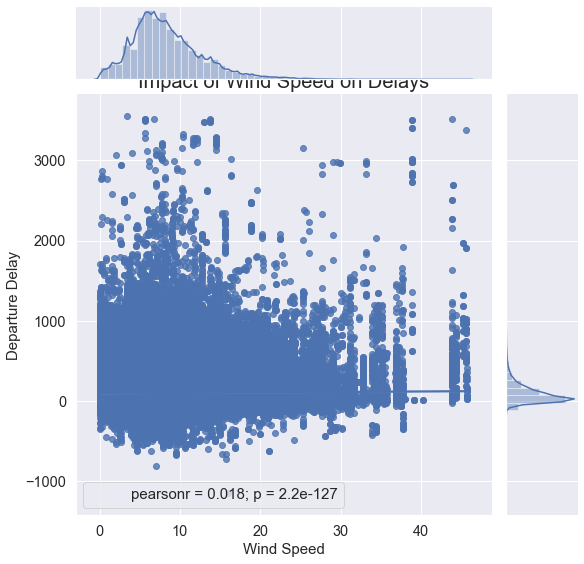

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1838225 entries, 0 to 1838224
Data columns (total 103 columns):
 #   Column                                Non-Null Count    Dtype         
---  ------                                --------------    -----         
 0   SERIAL_NUMBER                         1838225 non-null  int64         
 1   SCHEDULE_NAME                         1838225 non-null  object        
 2   SIGNUP_NAME                           1838225 non-null  object        
 3   SURVEY_SOURCE                         1838225 non-null  int64         
 4   PATTERN_ID                            1838225 non-null  int64         
 5   BRANCH                                1838225 non-null  object        
 6   ROUTE_NUMBER                          1838225 non-null  int64         
 7   ROUTE_NAME                            1838225 non-null  object        
 8   DIRECTION_NAME                        1838225 non-null  object        
 9   SERVICE_TYPE                          1838225

In [122]:
# Note these functions take a while to run. Instead, consider a single one or sampling
weather_correlation(train_master, 'Snow Depth')
weather_correlation(train_master, 'Precipitation')
weather_correlation(train_master, 'Wind Speed')
train_master.info(verbose=True, null_counts=True)

# Print out dataframe for subsequent ipython notebooks to read in

In [123]:
print(train_master.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1838225 entries, 0 to 1838224
Data columns (total 103 columns):
 #   Column                                Dtype         
---  ------                                -----         
 0   SERIAL_NUMBER                         int64         
 1   SCHEDULE_NAME                         object        
 2   SIGNUP_NAME                           object        
 3   SURVEY_SOURCE                         int64         
 4   PATTERN_ID                            int64         
 5   BRANCH                                object        
 6   ROUTE_NUMBER                          int64         
 7   ROUTE_NAME                            object        
 8   DIRECTION_NAME                        object        
 9   SERVICE_TYPE                          object        
 10  SERVICE_MODE                          object        
 11  SURVEY_DATE_EFFECTIVE                 object        
 12  SURVEY_DATE_ATYPICAL                  int64         
 13  TIME_PERIOD

In [124]:
pd.DataFrame(train_master).to_csv('train_master.csv',header=True,index=True)